In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.stats import f_oneway
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from scipy.stats import kruskal
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.regions_clusters import regions, country_to_region
from src.utils.plots_standards import styles, genres_colors, regions_colors
from src.scripts import ratings_statistics
from src.scripts import ratings_visualizations

# 1 - Data loading

In [2]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
#df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

The movies and characters dataset do require significant cleaning, as is presented below.

# 2 - Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [4]:
# the df_tmdb dataframe has many duplicates for titles but these could be movies with the same title that are different or movies that are the same
# but are different in features on these movies
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [5]:
# Altering the release date feature in the TMDB dataframe and in the moves dataframe to match, for unique index creation

# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])

# cleaning dates format
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

# unique indexes definition
title_release_movies = df_movies.title + df_movies.release_date.astype(str)
title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)

# copies of df_movies and df_tmdb for merging, with new index definition
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

# deleting temporary copies of df_movies and df_tmdb
del df_movies_copy
del df_tmdb_copy

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [6]:
# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [7]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [8]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [9]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [10]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [11]:
# remove movies with no genre reported, as this feature will be fundamental in subsequent analysis
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [12]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [13]:
# IMDB references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from imdb mean ratings using tmdb as linker as it has imdb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [14]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [15]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

In [16]:
# Dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# Evaluating movies with one country
country_1perc, country_1entries = cleaning.count_entries(df_movies_ratings_imdb, 'countries')

# printing the results
print(f"{country_1perc*100:.2f} % of our ratings-populated movie metadataset have only one country listed.")

# Keeping movies with one country for further analysis
df_movies_ratings_imdb = country_1entries

# dropping counts column
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['counts'], axis = 1)

86.52 % of our ratings-populated movie metadataset have only one country listed.


Given most movies have only one country listed, the other movies with more than one country have been dropped to avoid redundancy of considering the same movie and thereby rating across regions.

In [17]:
# Evaluate movies with 1 to 6 genres
percentages, subsets = cleaning.evaluate_genre_counts(df_movies_ratings_imdb, 'genres', 6)

# Print the results
for i in range(1, 7):
    print(f"{percentages[f'1_to_{i}_genre']*100:.2f} % of our ratings-populated movie metadataset have 1 to {i} genres listed.")

19.82 % of our ratings-populated movie metadataset have 1 to 1 genres listed.
39.23 % of our ratings-populated movie metadataset have 1 to 2 genres listed.
56.90 % of our ratings-populated movie metadataset have 1 to 3 genres listed.
72.01 % of our ratings-populated movie metadataset have 1 to 4 genres listed.
83.07 % of our ratings-populated movie metadataset have 1 to 5 genres listed.
90.43 % of our ratings-populated movie metadataset have 1 to 6 genres listed.


The majority of movies do not have one genre listed, so some way of handling this must be considered. One technique could be to explode the genre lists for multigenre movies, select for the top 20 (or some other value) most occurring genre, and then recombine the multigenre movies with only these relevant genres. However, considering we'd want to keep at least 90% of the movies which corresponds to movies having up to six genres, then in the 'worst-case' scenario there could be 6^20 possible recombinations of the top 20 genres. Our data would obviously not explore this entire combinatorial space, however, we would be analying hundreds of genres. Alternatively, the first genre listed in a movie's entry could be considered as the most relevant one and kept as the sole genre for multigenre movies. The issue here is we fear we are missing information about movies if we discard their other pertinent genres. Instead, we opt to explode all movies genres, then select for the top 20 most occurring genres, then preserve only movie entries with one of those top 20 genres listed.

In [18]:
# exploding genres
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# the genres column needs cleaning to ensure the same genres aren't doubled in a different format
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" film", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" movies", "")

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("[", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("]", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("'", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace('"', "")

In [19]:
# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

In [20]:
# the spoken languages, countries and genres columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.capitalize()

# capitalizing top_20_genres list
top_20_genres = [item.capitalize() for item in top_20_genres]

In [21]:
# final ordering of the standard dataframe
df_movies_ratings_imdb = df_movies_ratings_imdb.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_ratings_imdb['revenue'] = df_movies_ratings_imdb['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_ratings_imdb['revenue'] = pd.to_numeric(df_movies_ratings_imdb['revenue'], errors='coerce')

In [22]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_ratings_imdb['budget'] = df_movies_ratings_imdb['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `revenue`, `production_companies`, `spoken_languages` (recall that `'original_language'` with 0% missing data is available).

In [23]:
print(f"There are now {len(df_movies_ratings_imdb['title'].unique())} unique movies in the standard movies dataset.")
print(f"There were {len(df_movies)} unique movies in the initial movies dataset.")

There are now 32972 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


Part of our analysis involves considering geographical groupings, which have been manually clustered by production region. Therefore, we will now add the `region` column to the Master Dataframe.

In [24]:
# Map the 'countries' column to the 'region' column
df_movies_ratings_imdb['region'] = df_movies_ratings_imdb['countries'].map(country_to_region)

# entries for which a region was not assigned are dropped
df_movies_ratings_imdb = df_movies_ratings_imdb.dropna(subset=['region'])

In [25]:
# a dataframe with unique movie titles is now defined and will be used alongside df_movies_ratings_imdb
df_movies_ratings_imdb_unique = cleaning.drop_most_missing(df_movies_ratings_imdb, ['title'])

# drop 'missing_values' column of df_movies_ratings_imdb
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_ratings_imdb_unique = df_movies_ratings_imdb_unique.drop_duplicates(subset='title')

`df_movies_ratings_imdb` and `df_movies_ratings_imdb_unique` are now the master movies dataframes. In the following sections, these dataframes might undergo some modifications, therefore copies will be created at the beginning of each section to maintain the original datasets. The naming convention will be the following:
- `df_movies_ratings_imdb` --> `df_movies_###`, where `###` represents the section (e.g. `###` = `visuals` for section 4);
- `df_movies_ratings_imdb_unique` --> `df_movies_###_unique`

# 3 - Characters dataset wrangling

# 4 - Movies basic visuals

To begin analyzing the movie and characters datasets in their wrangled form, some general information about the movies dataframe are retrieved to better understand the underlying statistics of some important features.

In [26]:
# copies of the master dataframes to proceed with the analysis
df_movies_visuals = df_movies_ratings_imdb.copy()
df_movies_visuals_unique = df_movies_ratings_imdb_unique.copy()

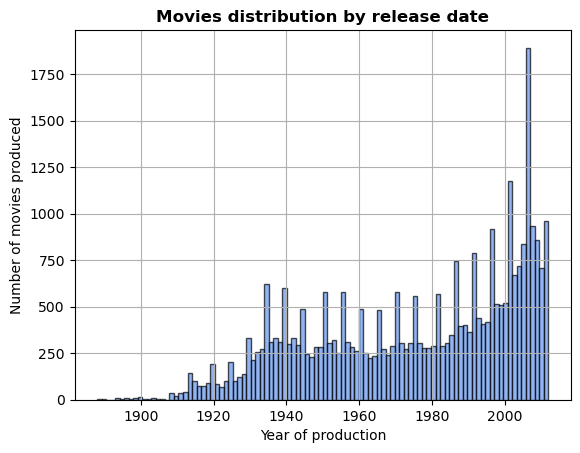

In [27]:
# Movies distribution by release date
plt.figure()
plt.title('Movies distribution by release date', weight='bold')
plt.hist(df_movies_visuals_unique['release_date'], bins= 100, **styles['hist_style'])
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True)
plt.show()

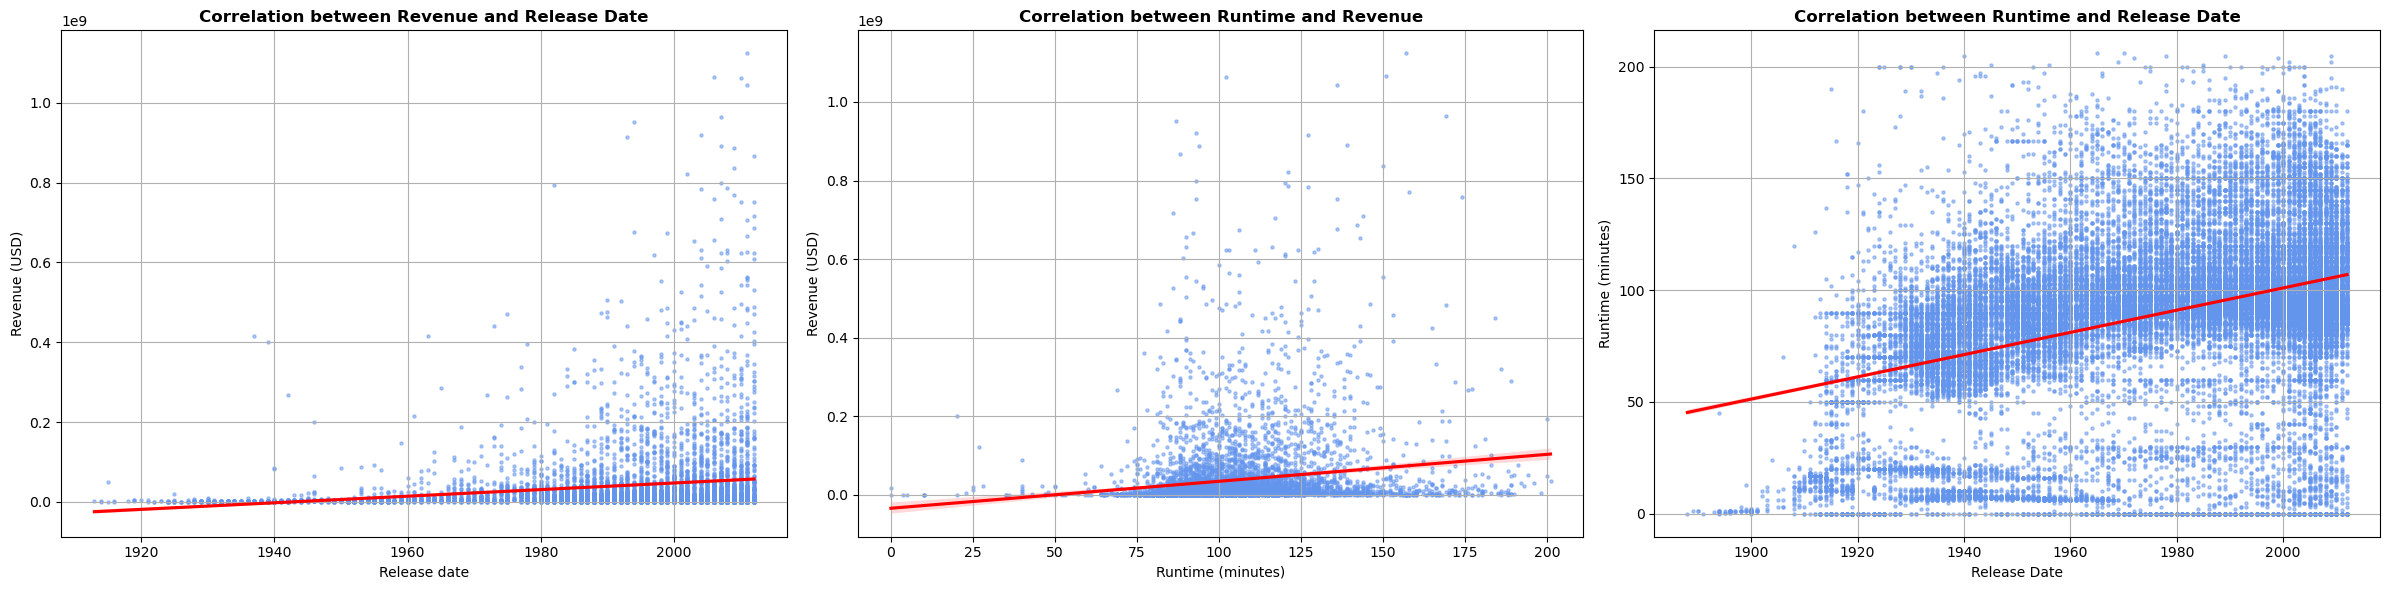

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Scatter-plot for release date vs revenue
sns.regplot(
    ax=axes[0],
    x='release_date',
    y='revenue',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[0].set_title('Correlation between Revenue and Release Date', weight='bold')
axes[0].set_xlabel("Release date")
axes[0].set_ylabel("Revenue (USD)")
axes[0].grid(True)

# Scatter-plot for runtime vs revenue
sns.regplot(
    ax=axes[1],
    x='runtime',
    y='revenue',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[1].set_title('Correlation between Runtime and Revenue', weight='bold')
axes[1].set_xlabel("Runtime (minutes)")
axes[1].set_ylabel("Revenue (USD)")
axes[1].grid(True)

# Scatter-plot for release date vs runtime
sns.regplot(
    ax=axes[2],
    x='release_date',
    y='runtime',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[2].set_title('Correlation between Runtime and Release Date', weight='bold')
axes[2].set_xlabel("Release Date")
axes[2].set_ylabel("Runtime (minutes)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

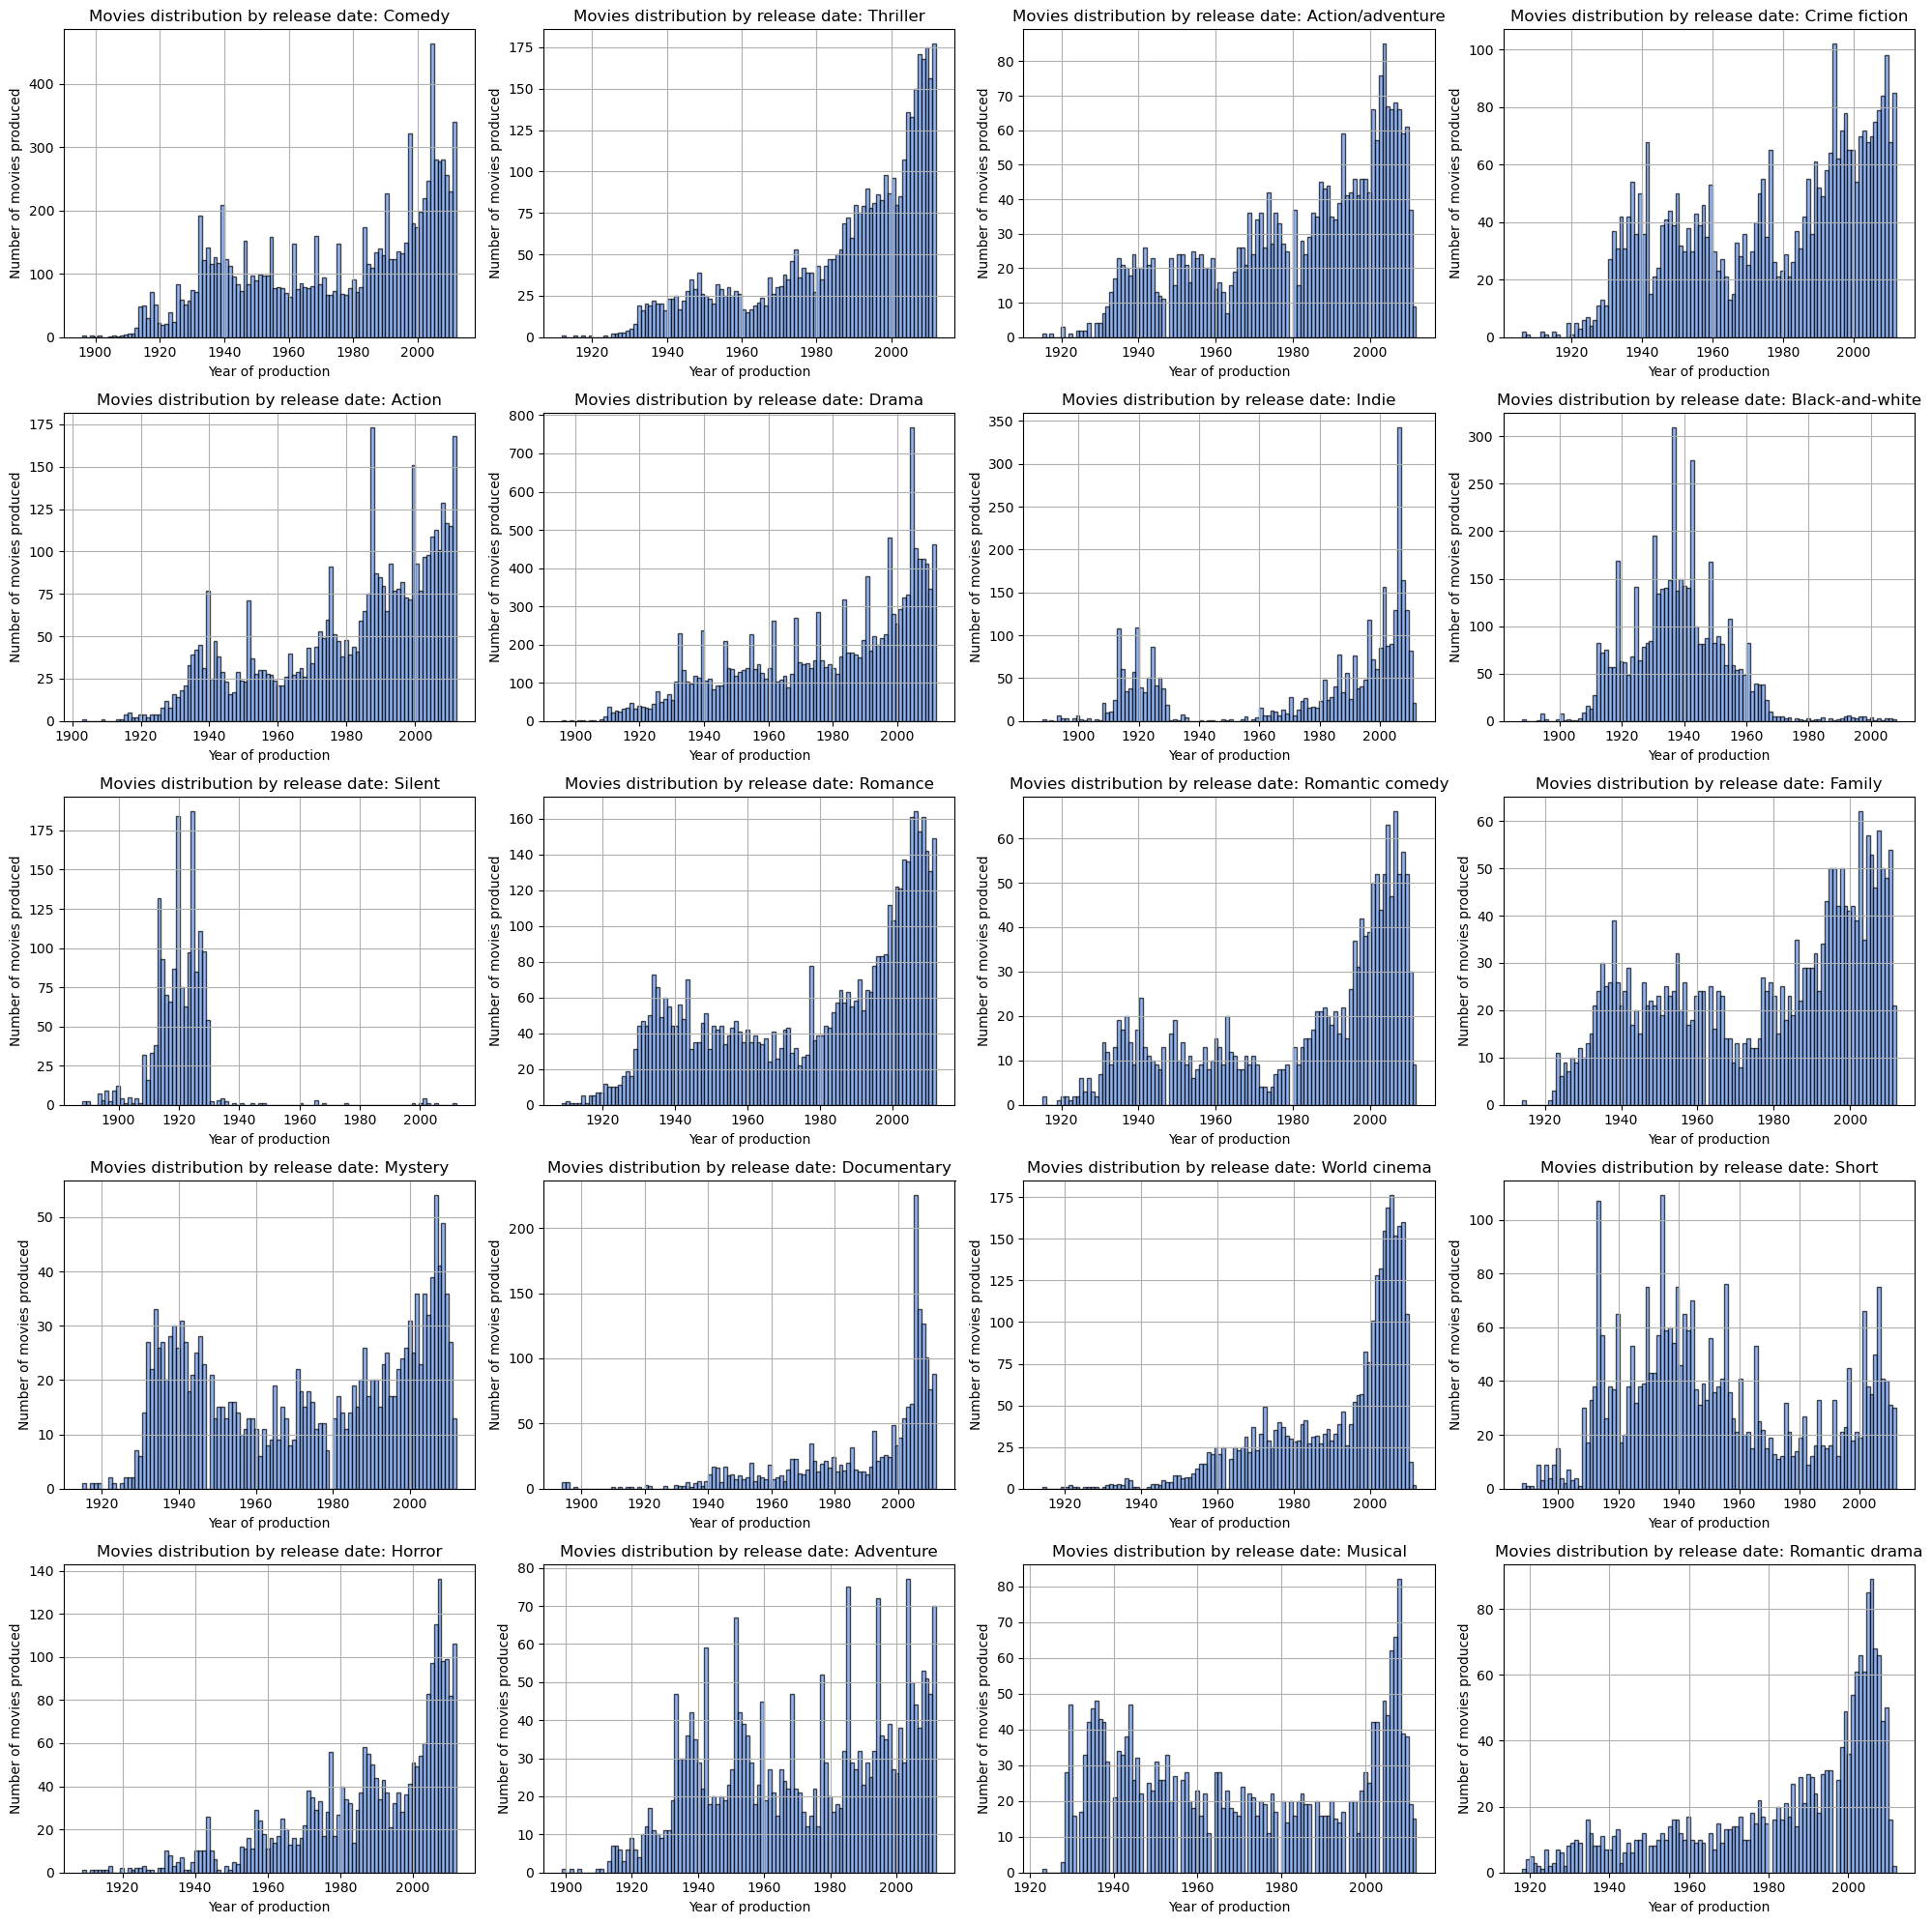

In [29]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# looping over genres
for i, genre in enumerate(df_movies_visuals['genres'].unique()):
    # selecting current axes
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {genre}')

    # plotting the histogram for the current genre
    ax.hist(df_movies_visuals[df_movies_visuals['genres'] == genre]['release_date'], bins= 100, **styles['hist_style'])

    # labels and limits
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')
    ax.grid(True)

plt.tight_layout()

# 5 - Ratings Analysis

In [30]:
# copies of the master dataframes to proceed with the analysis
df_movies_ratings = df_movies_ratings_imdb.copy()
df_movies_ratings_unique = df_movies_ratings_imdb_unique.copy()

The analysis is heavily based on the `averageRating` feature. To better understand its statistics, its description is displayed.

In [31]:
df_movies_ratings["averageRating"].describe()

count    77948.00000
mean         6.16238
std          1.08109
min          1.10000
25%          5.60000
50%          6.30000
75%          6.90000
max          9.50000
Name: averageRating, dtype: float64

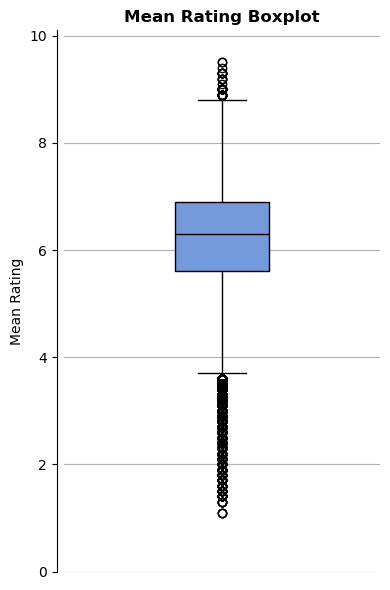

In [32]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_ratings['averageRating'], **styles['boxplot_style'])

# box-plotting the 'mean_rating' column
sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,10.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

plt.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a ten point scale and no extreme values greatly drive skew in the movies ratings. The plot below provides further information on the mean movie ratings distribution.

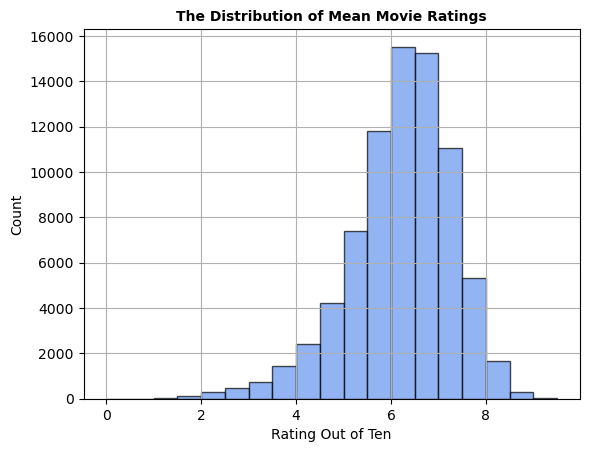

In [33]:
# defining bins
bin_edges = np.arange(0, df_movies_ratings['averageRating'].max() + 0.5, 0.5)

plt.hist(df_movies_ratings['averageRating'].values, bins = bin_edges, **styles['hist_style'])
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Ten', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True)

Since even through this visualization the distribution resembles a normal one, some test to verify this hypothesis are run below.

In [34]:
diagnostic.kstest_normal(df_movies_ratings['averageRating'].values, dist = 'norm')

(0.07208240893274553, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, visual inspections of the ratings distribution lead to a different conclusion. Therefore, a Q-Q plot is also employed to further assess normality.

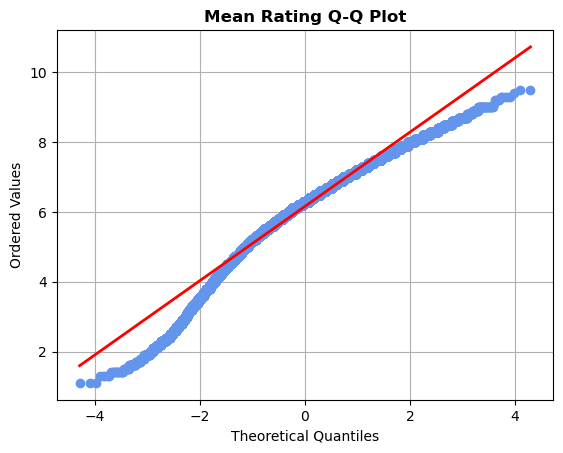

In [35]:
# ploting Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_ratings['averageRating'].values, dist="norm", plot=ax)

# line settings
ax.get_lines()[0].set_color('cornflowerblue') 
ax.get_lines()[0].set_linewidth(2)
ax.get_lines()[1].set_color('red') 
ax.get_lines()[1].set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

Now, a closer look to genres preferences is presented. The objective is to visualize if the mean movie rating changes, based on the movie genre.

Text(50.72222222222221, 0.5, 'Genres')

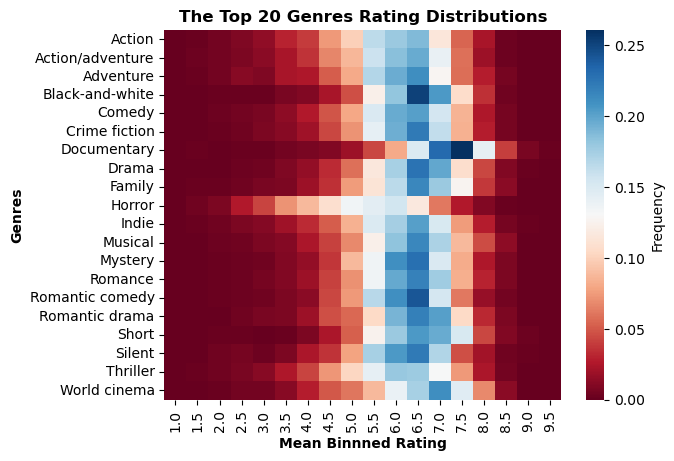

In [36]:
# making the mean of each movie's rating an increment of 0.5
df_movies_ratings["binned_rating"] = df_movies_ratings["averageRating"].apply(lambda x: round(x*2)/2)

df_genres_meanratings = pd.crosstab(df_movies_ratings['genres'], df_movies_ratings['binned_rating'], normalize='index')

# creating an heatmap among the genres
ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='RdBu', ax = ax, cbar_kws={'label': 'Frequency'})
ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')

The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 4.5 and 7.5 rating bins, as expected given the population's mean rating of 6. Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since no evident movie genre preference has been found, other parameters are compared to the mean rating, to find correlations. For example, runtime and release date.

This is obviously difficult to visualize, so a density plot is used instead.

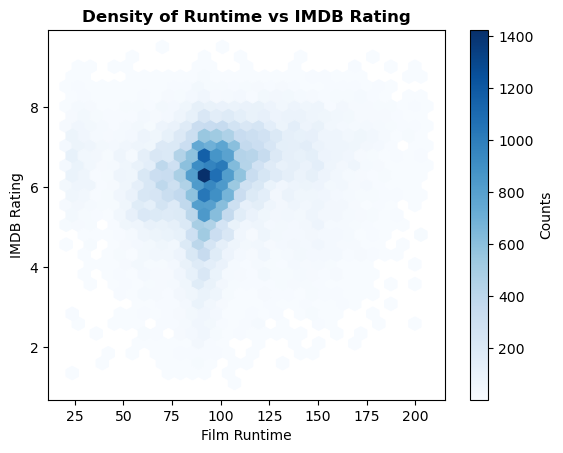

In [37]:
# starting by plotting the relationship between movies with reasonable runtimes (over 20 minutes, despite short films
# having lesser time than this as there are many incorrect runtimes observed under 20 minutes) and mean rating
df_movies_ratings_runtimes = df_movies_ratings[df_movies_ratings['runtime'] > 20.0]

plt.hexbin(df_movies_ratings_runtimes["runtime"], df_movies_ratings_runtimes["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Counts")
plt.xlabel("Film Runtime")
plt.ylabel("IMDB Rating")
plt.title("Density of Runtime vs IMDB Rating", weight='bold')
plt.show()

This relationship per genre would also be interesting.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


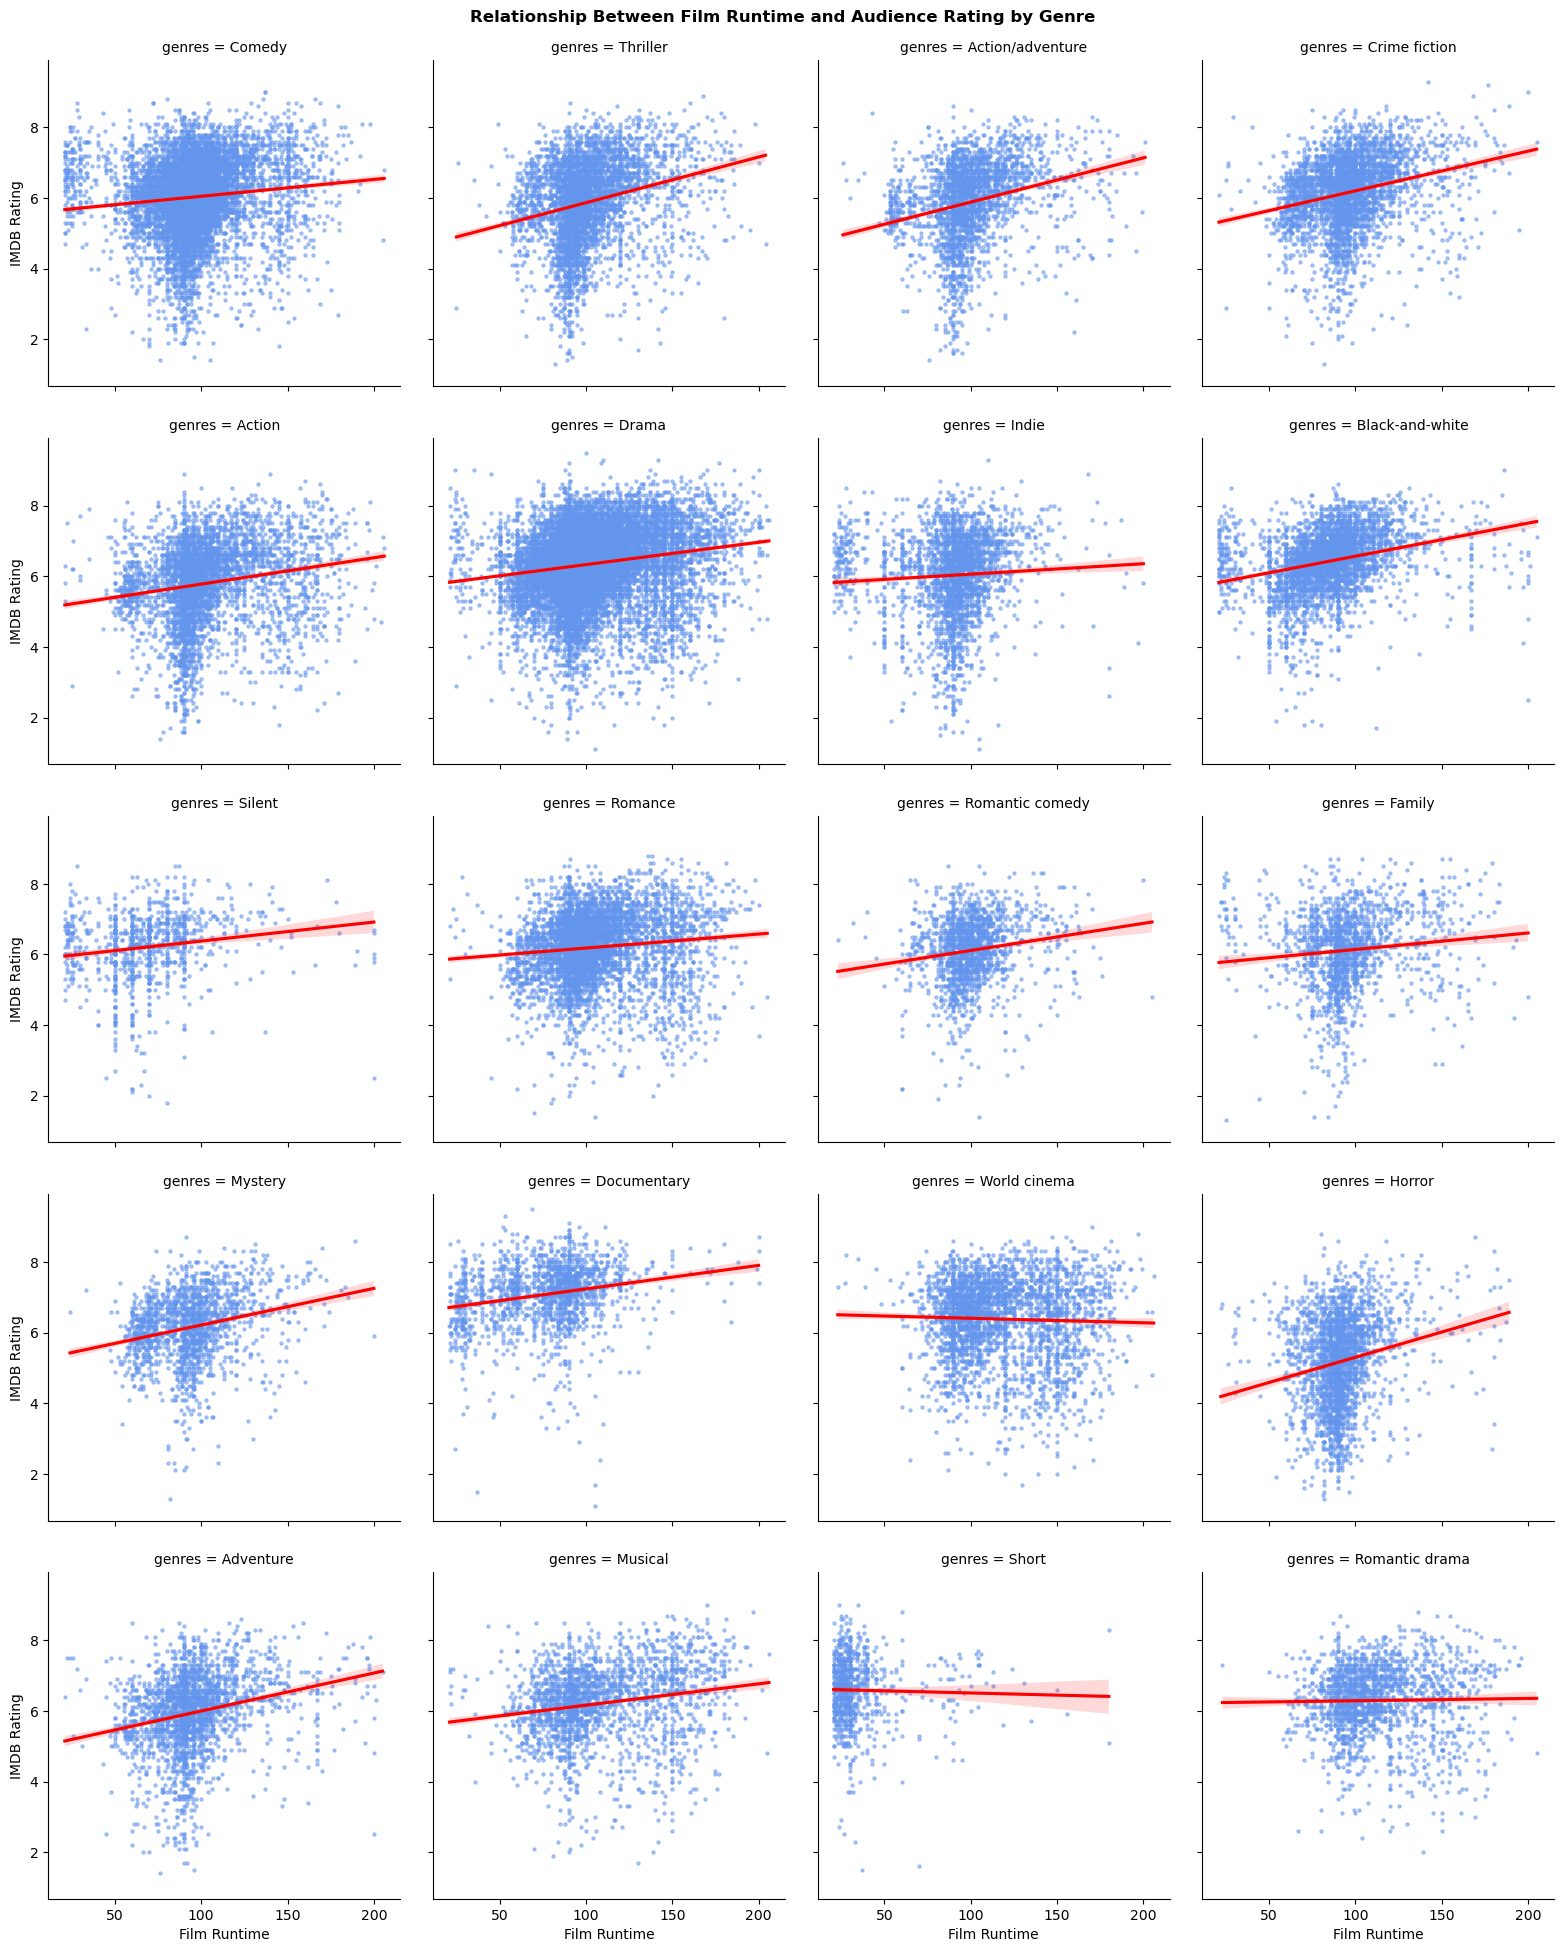

In [38]:
seperated_genres = sns.FacetGrid(df_movies_ratings_runtimes, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)
seperated_genres.map(sns.regplot, "runtime", "averageRating", scatter_kws=styles['scatter_style'], line_kws=styles['line_style'])
seperated_genres.set_axis_labels("Film Runtime", "IMDB Rating")
seperated_genres.fig.suptitle("Relationship Between Film Runtime and Audience Rating by Genre", weight='bold')
seperated_genres.tight_layout(pad=2)
plt.show()

In [39]:
# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_ratings_runtimes['runtime'], df_movies_ratings_runtimes['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_ratings_runtimes['runtime'], df_movies_ratings_runtimes['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.1222, p-value: 0.0000
Spearman correlation: 0.1767, p-value: 0.0000


The same plots can been computed to compare the rating and the release date.

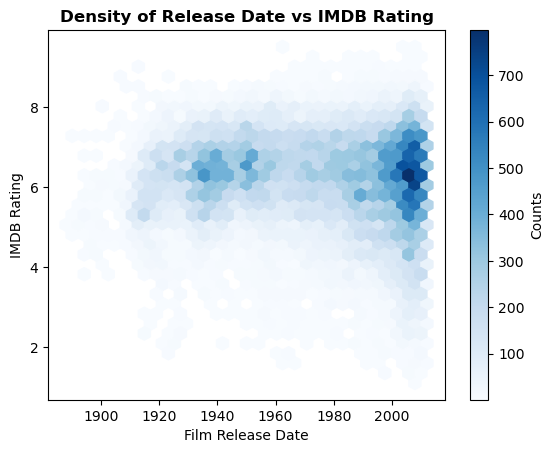

In [40]:
plt.hexbin(df_movies_ratings["release_date"], df_movies_ratings["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Counts")
plt.xlabel("Film Release Date")
plt.ylabel("IMDB Rating")
plt.title("Density of Release Date vs IMDB Rating", weight='bold')
plt.show()

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


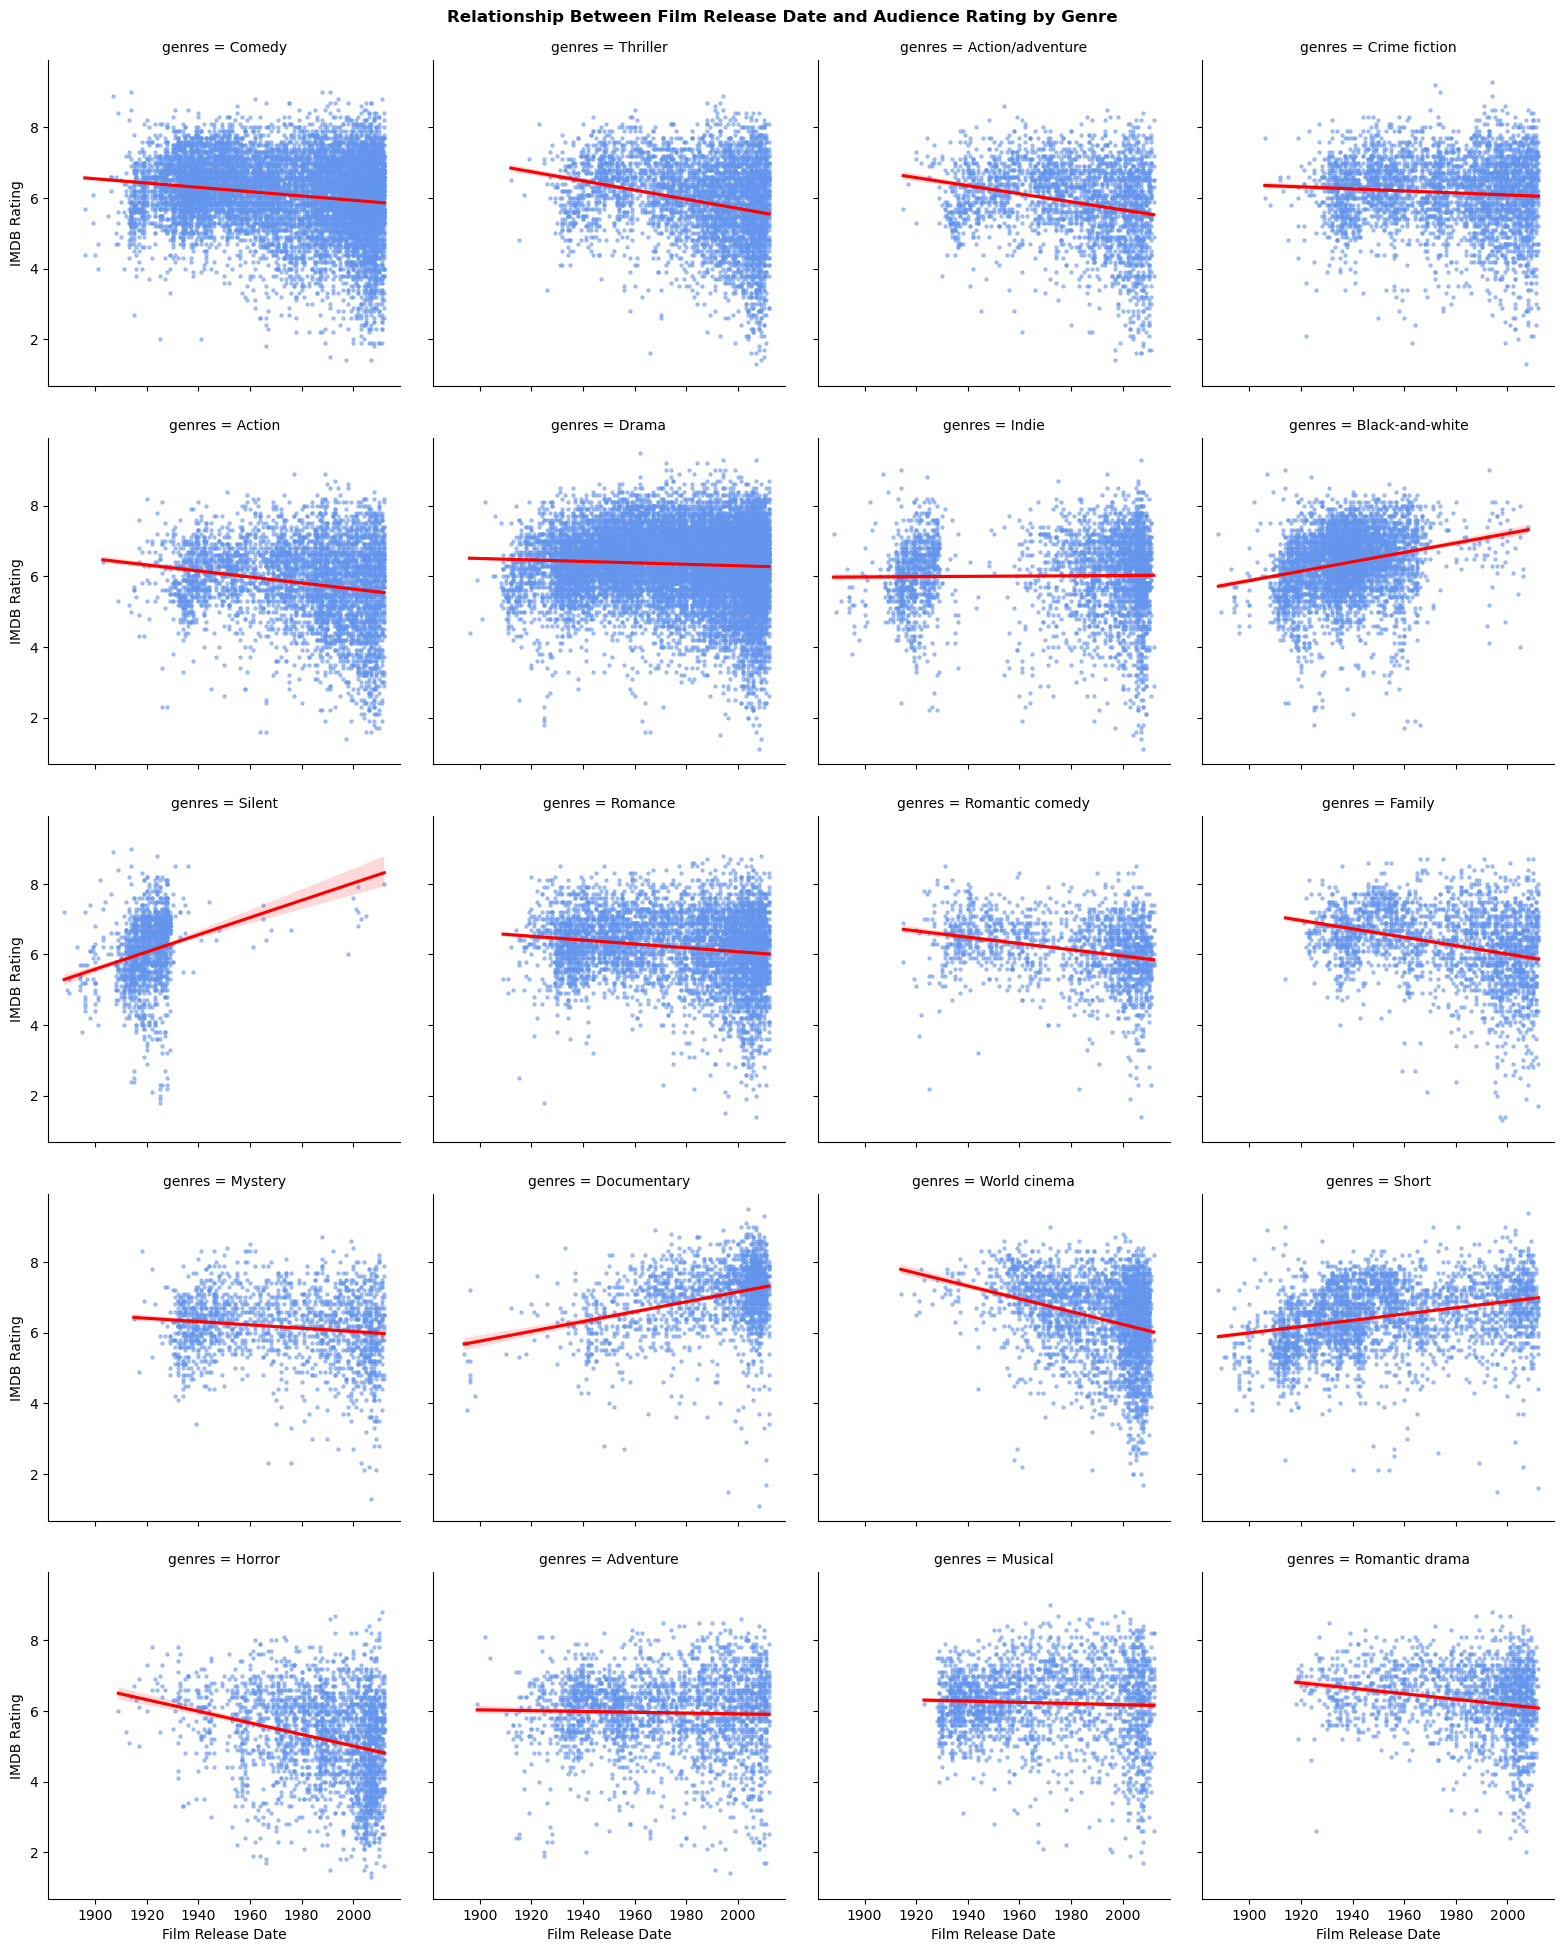

In [41]:
seperated_genres = sns.FacetGrid(df_movies_ratings, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)
seperated_genres.map(sns.regplot, "release_date", "averageRating", scatter_kws=styles['scatter_style'], line_kws=styles['line_style'])
seperated_genres.set_axis_labels("Film Release Date", "IMDB Rating")
seperated_genres.fig.suptitle("Relationship Between Film Release Date and Audience Rating by Genre", weight='bold')
seperated_genres.tight_layout(pad=2)
plt.show()

In [42]:
# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_ratings['release_date'], df_movies_ratings['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_ratings['release_date'], df_movies_ratings['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.1029, p-value: 0.0000
Spearman correlation: -0.0858, p-value: 0.0000


## 5.1 - Film ratings across regions and genres, over time

In [43]:
# Identifying if any country does not have a particular genre
for genre in top_20_genres:
    # indentifying unique regions for the current genre
    regions_with_genre = df_movies_ratings[df_movies_ratings["genres"] == genre]["region"].unique()

    # converting .tolist()
    regions_with_genre = regions_with_genre.tolist()

    # checking if the total number of regions for the current genre is equal to the total number of regions (9)
    if len(regions_with_genre) < 9:
        for region in list(regions.keys()):
            if region not in regions_with_genre:
                print(f"The geographical region {region} does not have a movie for the genre {genre}.")

The geographical region South Africa and Central Africa does not have a movie for the genre Black-and-white.
The geographical region North Africa and Middle East does not have a movie for the genre Indie.
The geographical region South Africa and Central Africa does not have a movie for the genre Musical.
The geographical region South Africa and Central Africa does not have a movie for the genre Silent.
The geographical region North Africa and Middle East does not have a movie for the genre Silent.


In [44]:
# Filling a copy dataframe with blank movie(s) for the missing genre(s) of any geographic region, to ensure no errors when plotting below
df_movies_ratings_regionfilled = df_movies_ratings.copy()

df_movies_ratings_regionfilled = filling.fill_missing_regions(
    df_movies_ratings_regionfilled,
    top_20_genres,    
    list(regions.keys())      
)

In [45]:
# checking if any country does not have a particular genre again, which shouldn't be the case
for genre in top_20_genres:
    # indentifying unique regions for the current genre
    regions_with_genre = df_movies_ratings_regionfilled[df_movies_ratings_regionfilled["genres"] == genre]["region"].unique()

    # converting .tolist()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for region in list(regions.keys()):
            if region not in regions_with_genre:
                print(f"The geographical region {region} does not have a movie for the genre {genre}.")
    else:
        print(f"Every region has at least one {genre} movie.")

Every region has at least one Drama movie.
Every region has at least one Comedy movie.
Every region has at least one Romance movie.
Every region has at least one Black-and-white movie.
Every region has at least one Action movie.
Every region has at least one Thriller movie.
Every region has at least one Crime fiction movie.
Every region has at least one Indie movie.
Every region has at least one Short movie.
Every region has at least one World cinema movie.
Every region has at least one Action/adventure movie.
Every region has at least one Horror movie.
Every region has at least one Adventure movie.
Every region has at least one Family movie.
Every region has at least one Musical movie.
Every region has at least one Documentary movie.
Every region has at least one Romantic drama movie.
Every region has at least one Mystery movie.
Every region has at least one Romantic comedy movie.
Every region has at least one Silent movie.


In [46]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_statistics(
    df_movies_ratings_regionfilled,
    top_20_genres,
    list(regions.keys())
)

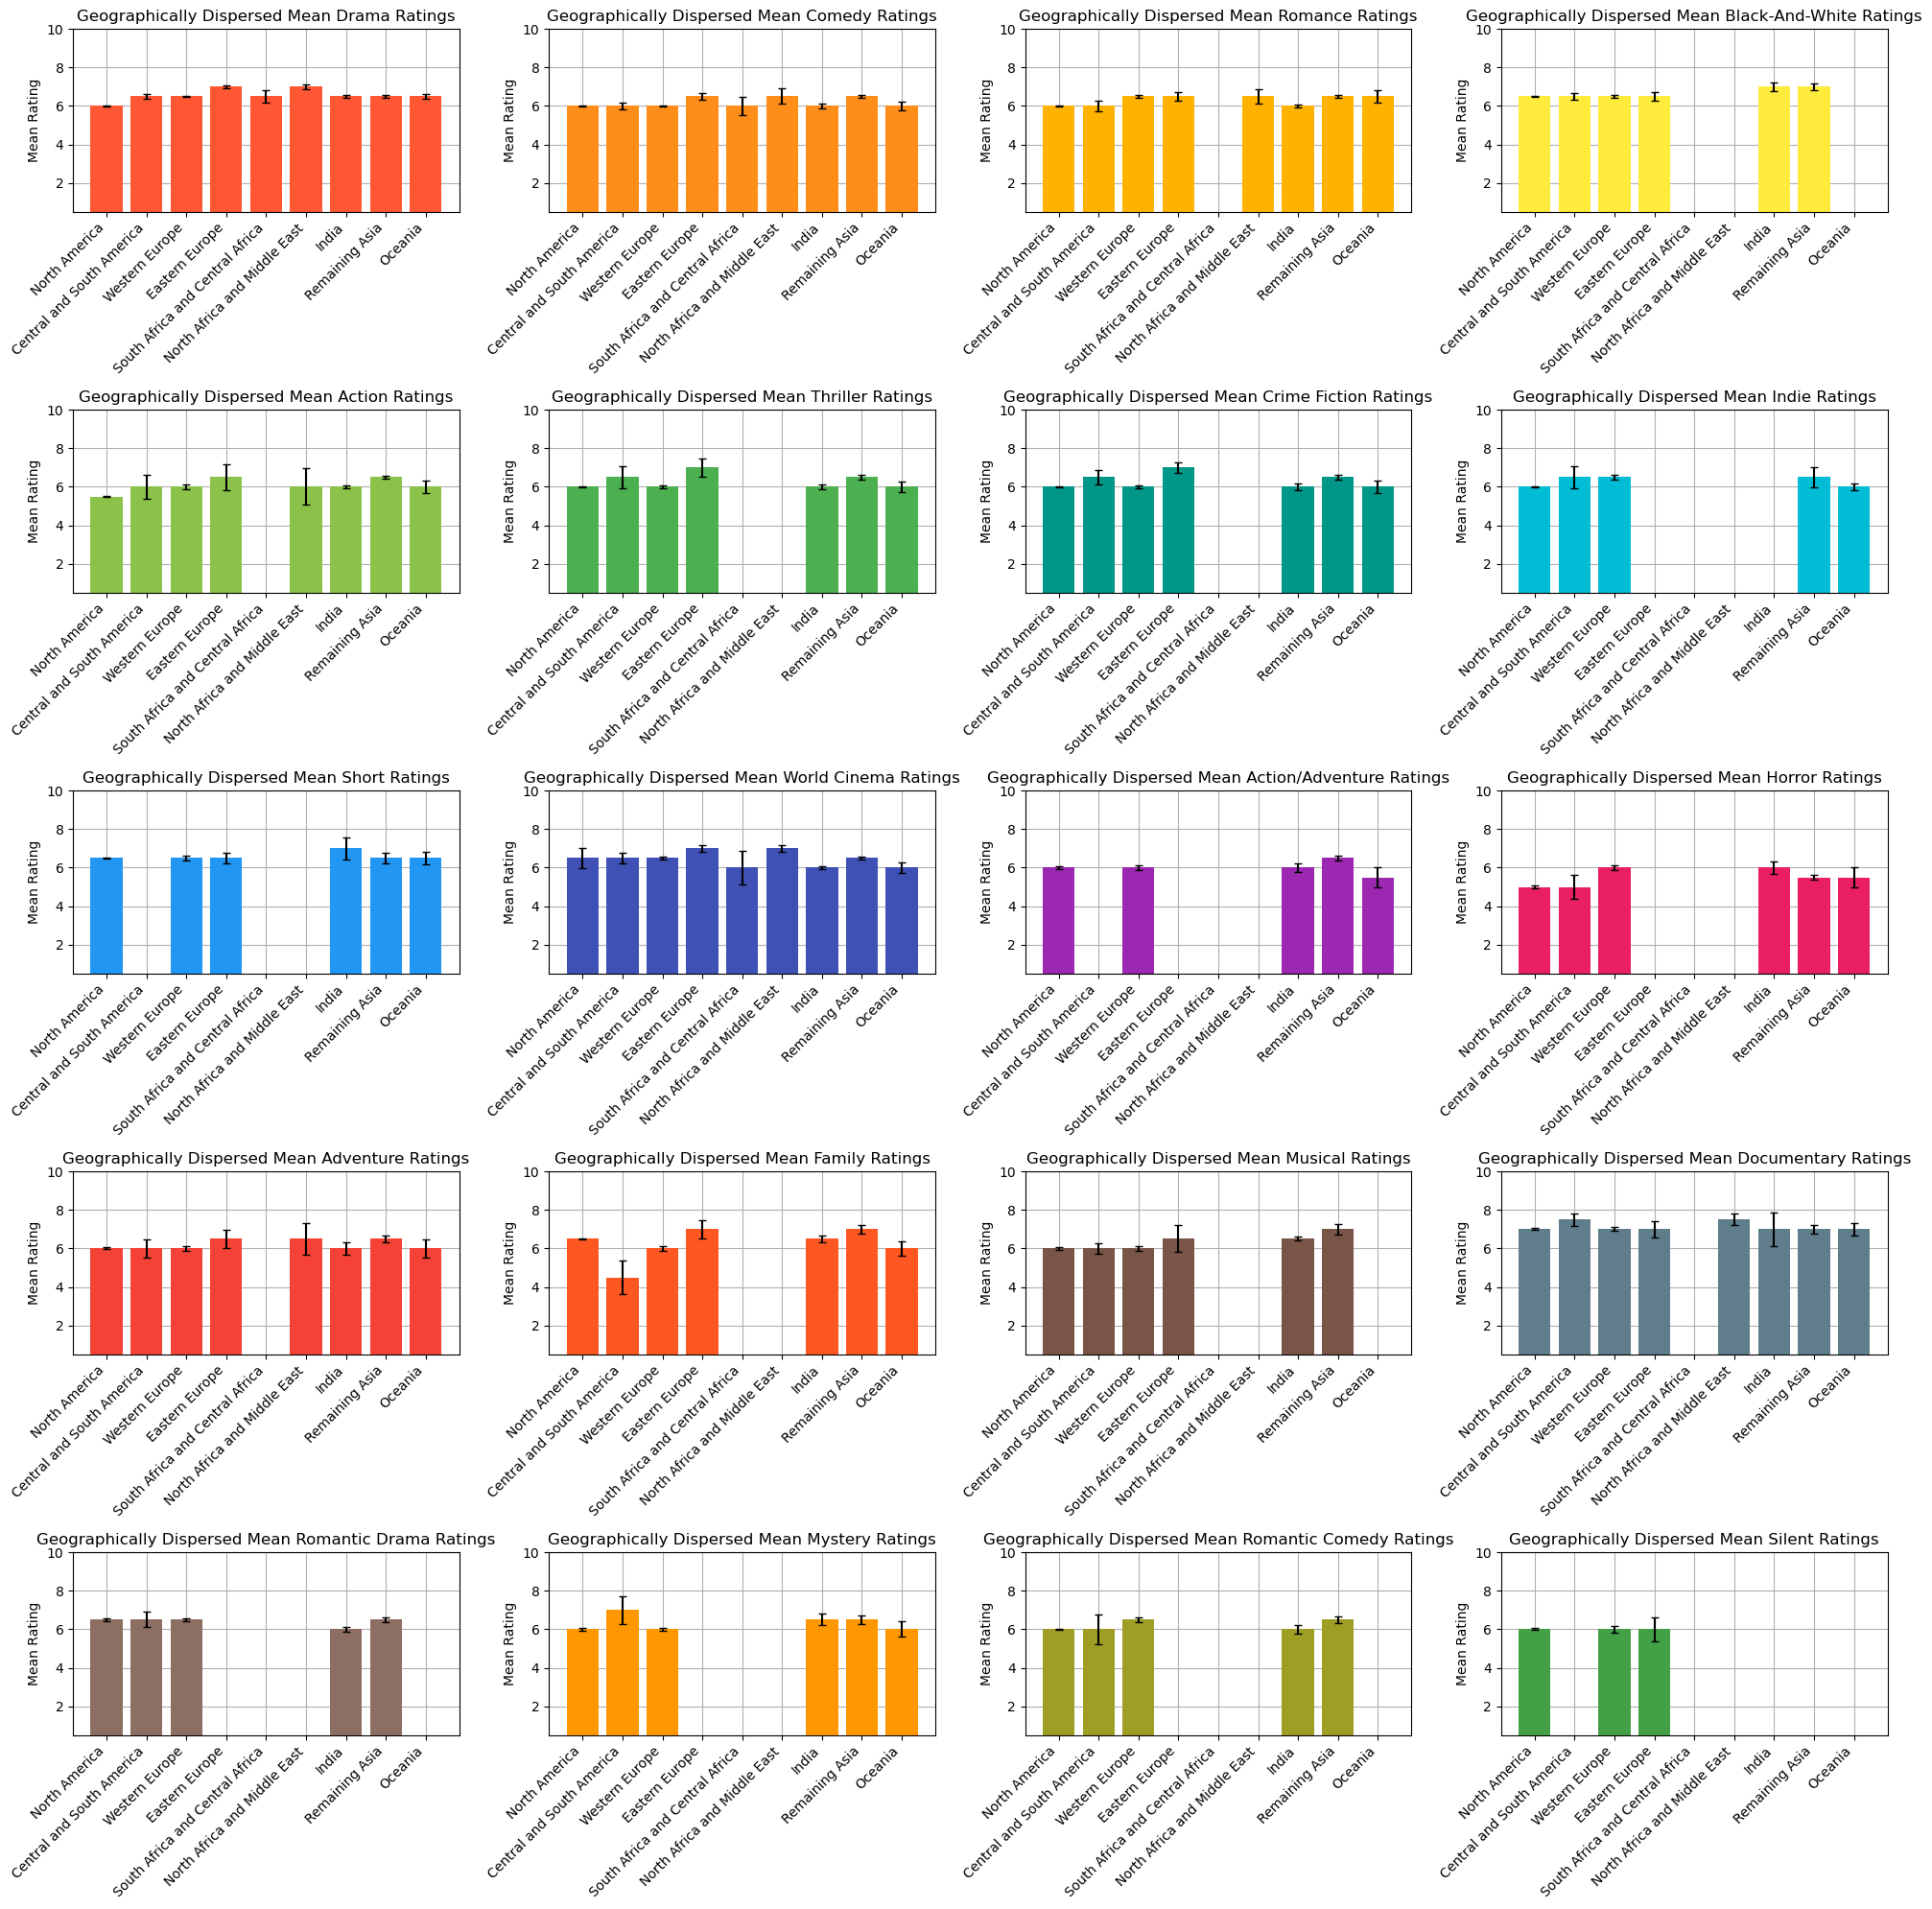

In [47]:
# Create a 5x4 grid for the subplots to fit 20 genres
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# Plot each genre in the corresponding subplot
for i, genre in enumerate(top_20_genres):
    axes[i].bar(range(len(list(regions.keys()))), mean_ratings[genre], yerr=confidence_intervals[genre], capsize=3, color=genres_colors[i], zorder=2)

    axes[i].grid(True, zorder=0)
    axes[i].set_xticks(range(len(list(regions.keys()))))
    axes[i].set_xticklabels(list(regions.keys()), rotation=45, ha='right')
    axes[i].set_title(f"Geographically Dispersed Mean {genre.title()} Ratings")
    axes[i].set_ylabel("Mean Rating")
    axes[i].set_ylim(0.5, 10)

# Adjust layout to fit everything well
plt.tight_layout()
plt.show()

Now we want to explore how within each geographical region the mean ratings of movies by genre differ.

In [48]:
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_statistics(
    df_movies_ratings_regionfilled,
    list(regions.keys()),
    top_20_genres
)

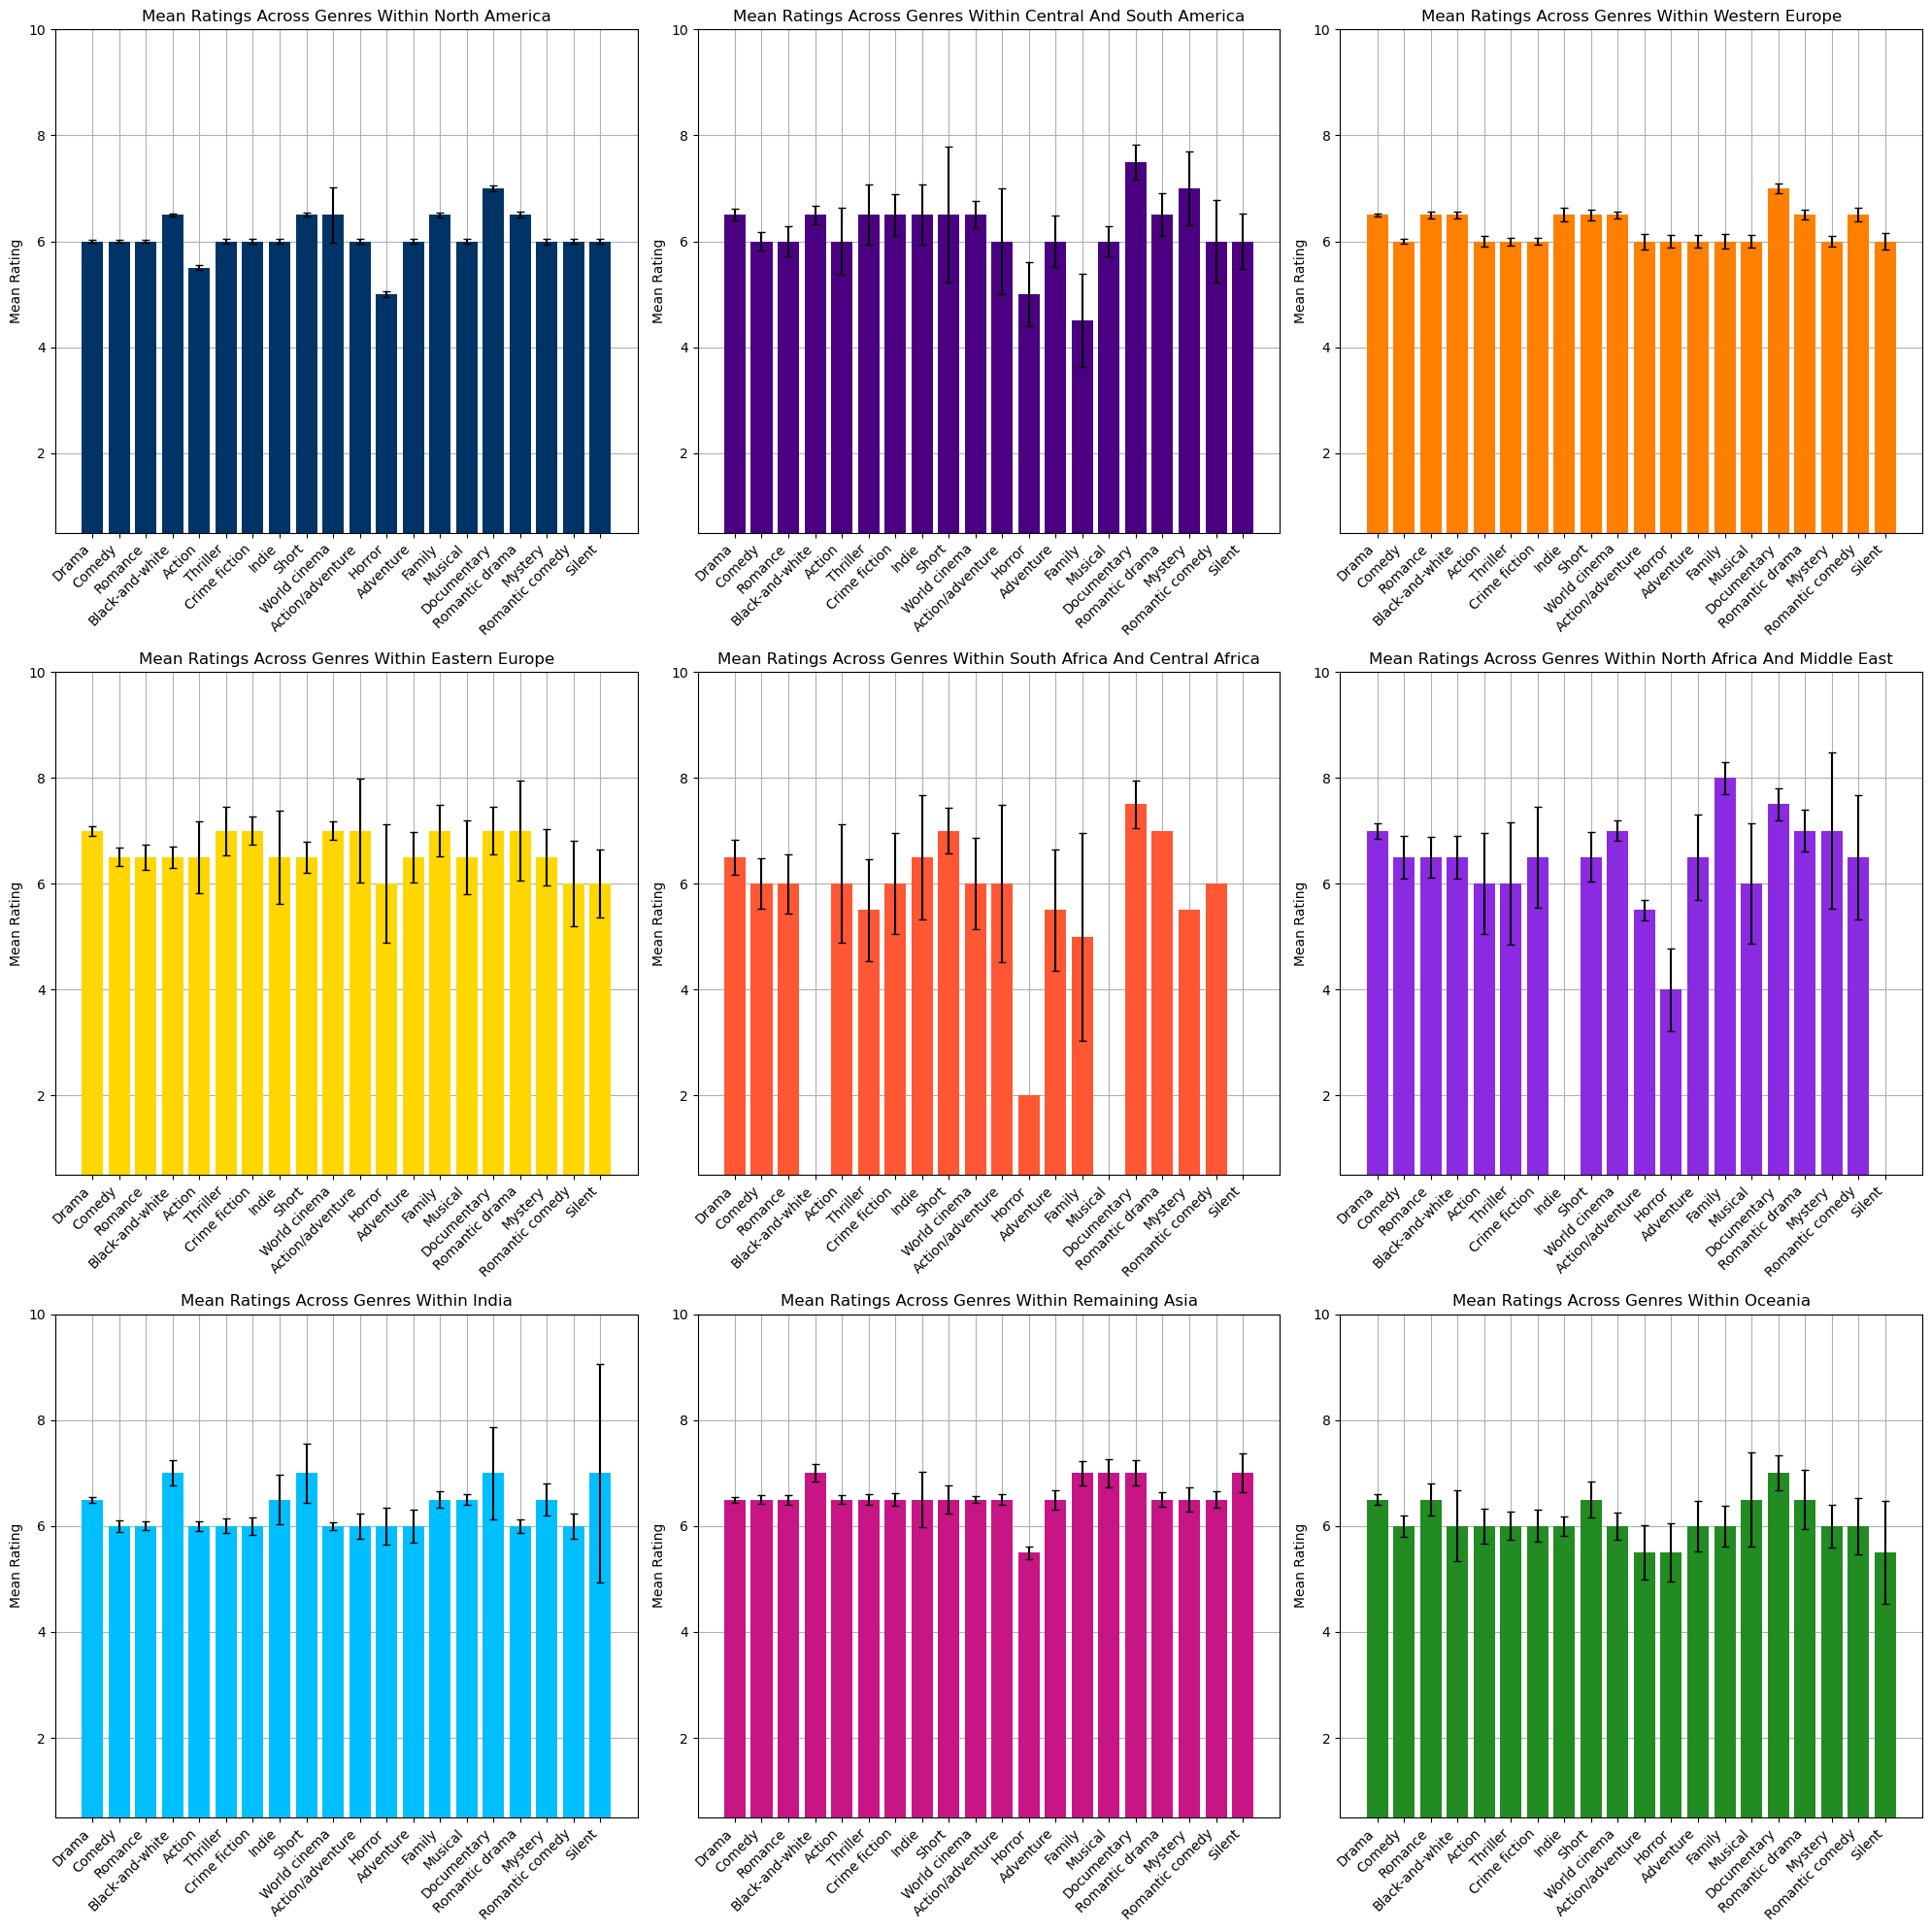

In [49]:
# Create a 3x3 grid for the subplots to fit 9 regions
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

# Plot each genre in the corresponding subplot
for i, region in enumerate(list(regions.keys())):
    axes[i].bar(range(len(top_20_genres)), mean_ratings[region], yerr=confidence_intervals[region], capsize=3, color=regions_colors[i], zorder=2)

    axes[i].grid(True, zorder=0)
    axes[i].set_xticks(range(len(top_20_genres)))
    axes[i].set_xticklabels(top_20_genres, rotation=45, ha='right')
    axes[i].set_title(f"Mean Ratings Across Genres Within {region.title()}")
    axes[i].set_ylabel("Mean Rating")
    axes[i].set_ylim(0.5, 10)

# Adjust layout to fit everything well
plt.tight_layout()
plt.show()

Now we want to observe how the mean rating per genre per region changes over time.

In [50]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# The movies must be 'binned' into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [51]:
# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

In [52]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_20_genres,               
    list(regions.keys()),                         
    decades               
)

In [53]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_decade_statistics(
    df_movies_ratings_region_decadefilled,
    list(regions.keys()),
    top_20_genres,
    decades  
)

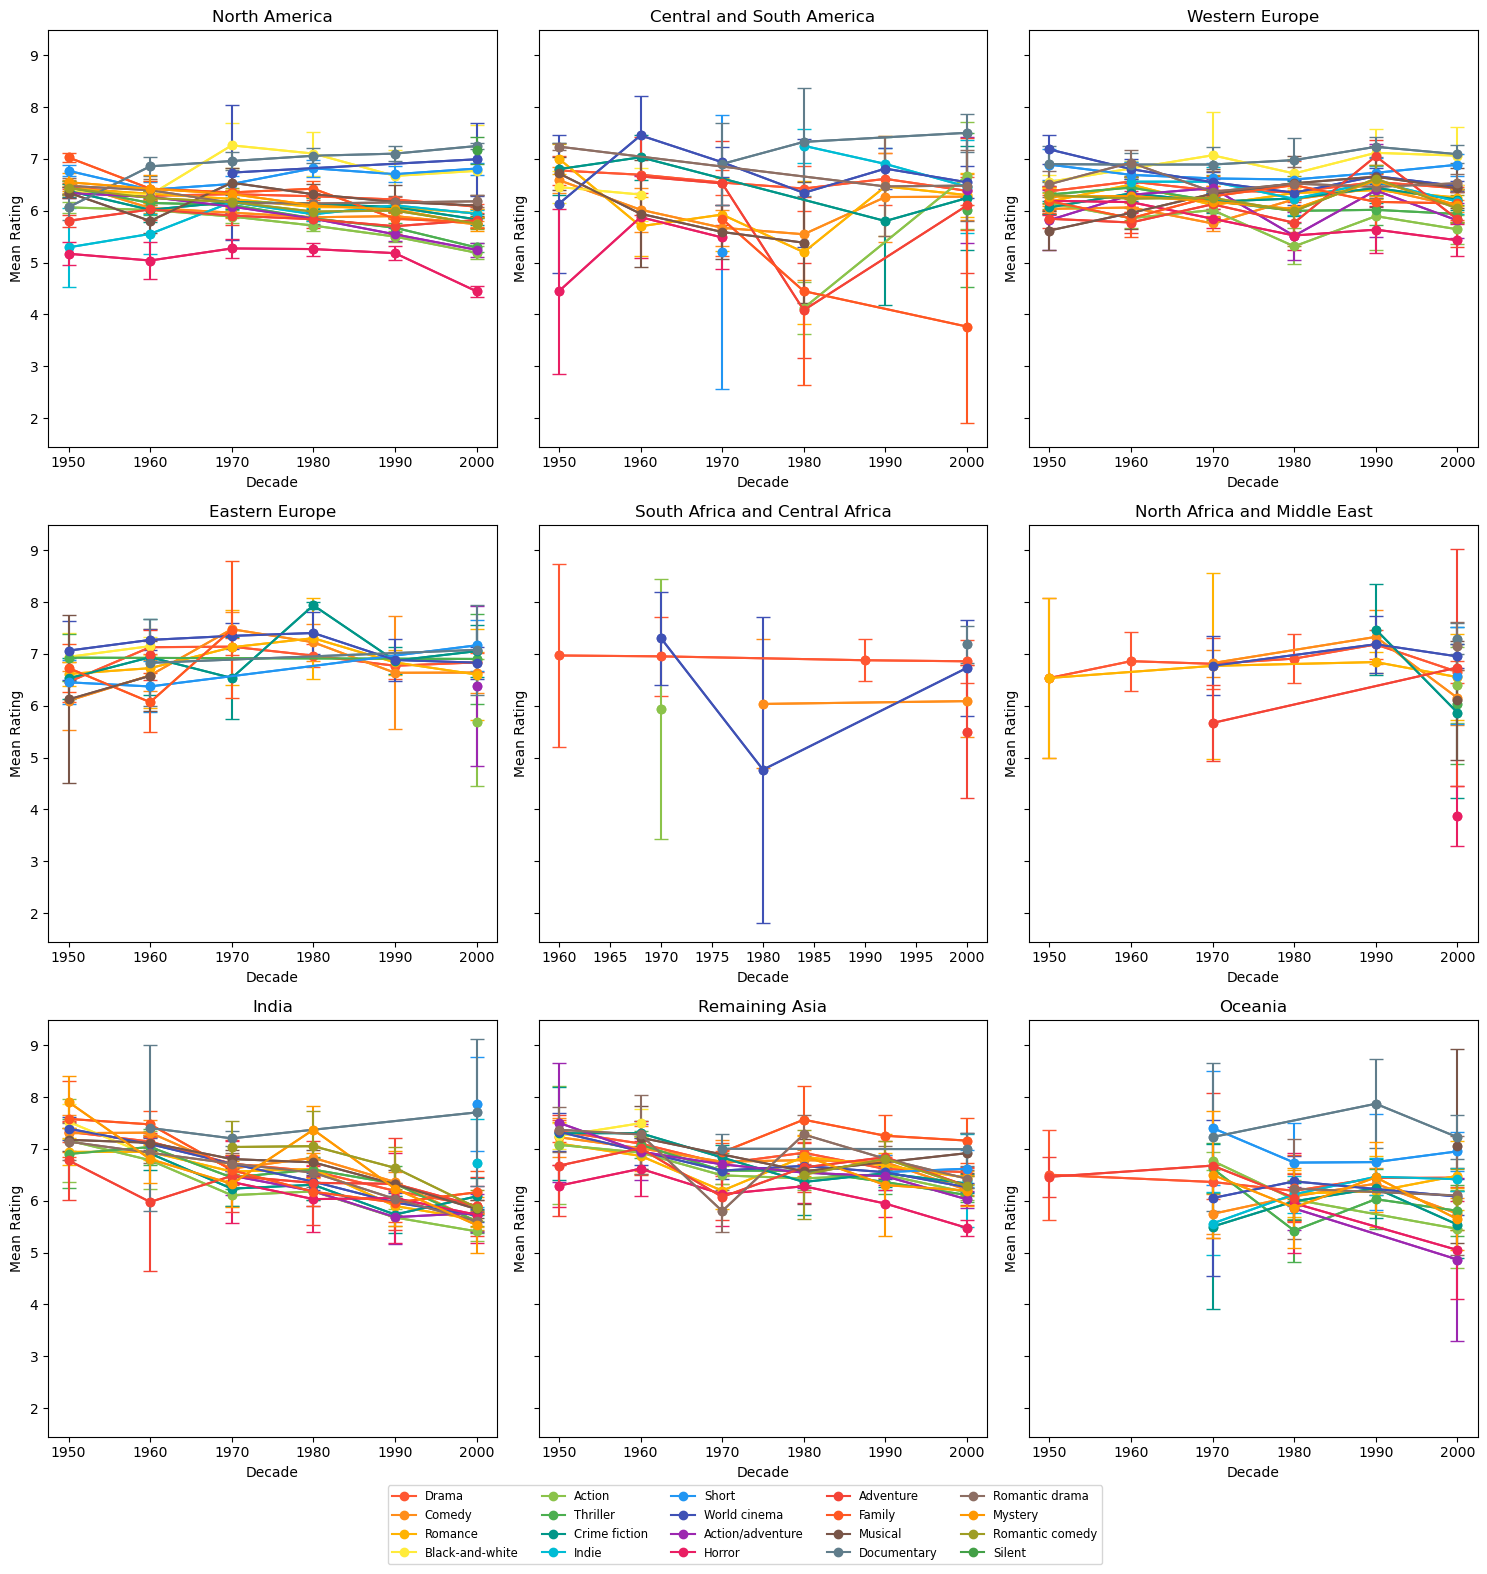

In [54]:
# plotting the results
ratings_visualizations.plot_region_genre_ratings(
    mean_ratings,           
    confidence_intervals,   
    decades,                
    top_20_genres,     
    genres_colors                  
)

The above is great but with 20 genres, quite hard to visualize. Let's focus on the top 6 genres to make the observations more readable, recycling the code from above.

In [55]:
# getting the top 6 genres as a list
top_6_genres = df_movies_ratings_imdb['genres'].value_counts().head(6).index.tolist()

In [56]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# The movies must be 'binned' into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [57]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_6_genres,               
    list(regions.keys()),                         
    decades               
)

In [58]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_decade_statistics(
    df_movies_ratings_region_decadefilled,
    list(regions.keys()),
    top_6_genres,
    decades  
)

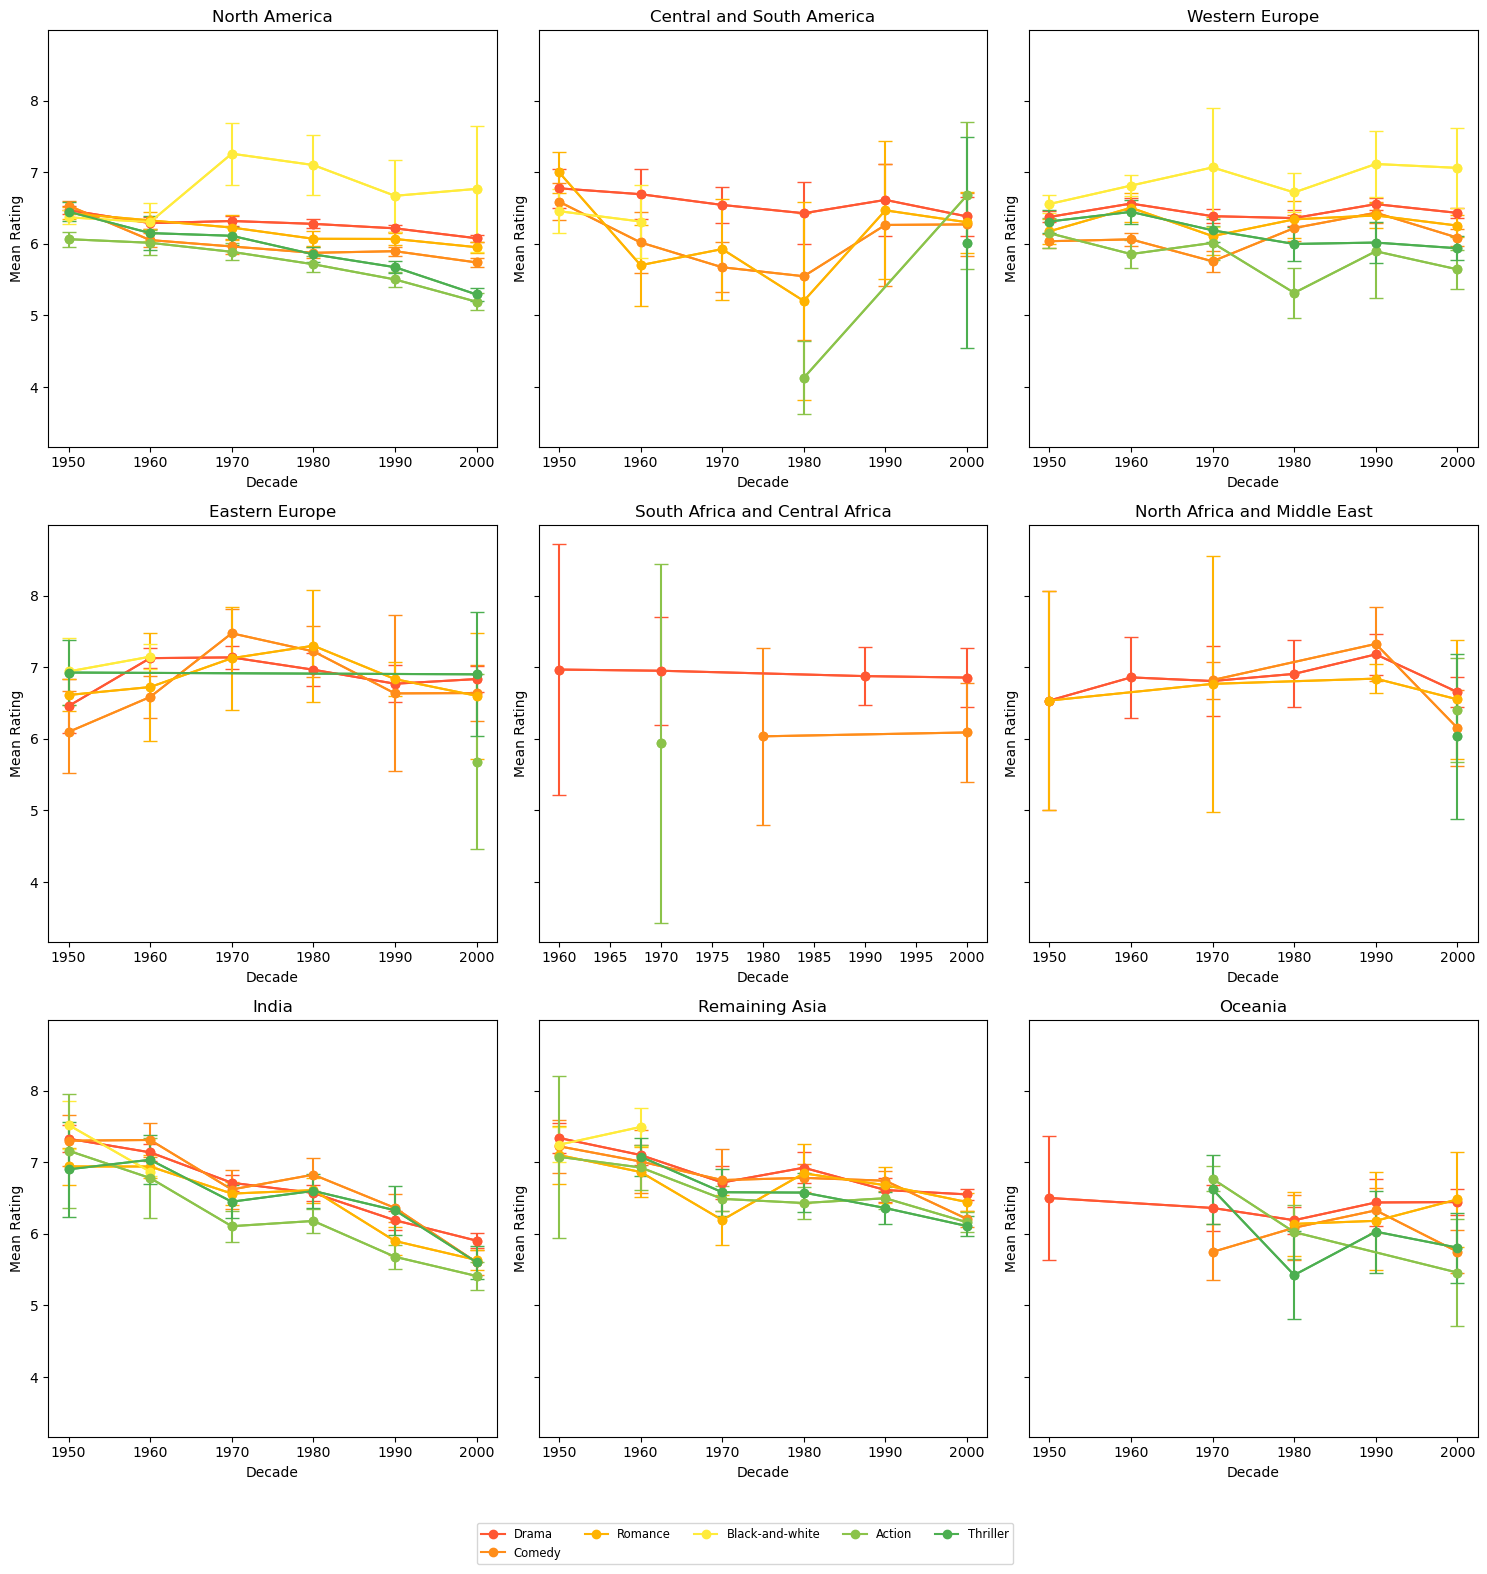

In [59]:
# plotting the results
ratings_visualizations.plot_region_genre_ratings(
    mean_ratings,           
    confidence_intervals,   
    decades,                
    top_6_genres,     
    genres_colors                  
)

Interesting! Let's now apply the analysis of comparing ratings across decades to analyzing the ratings across decades between regions per genre.

In [60]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# The movies must be 'binned' into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [61]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_6_genres,               
    list(regions.keys()),                         
    decades               
)

In [62]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_region_decade_statistics(
    df_movies_ratings_region_decadefilled, 
    top_6_genres,                             
    list(regions.keys()),                           
    decades                              
)

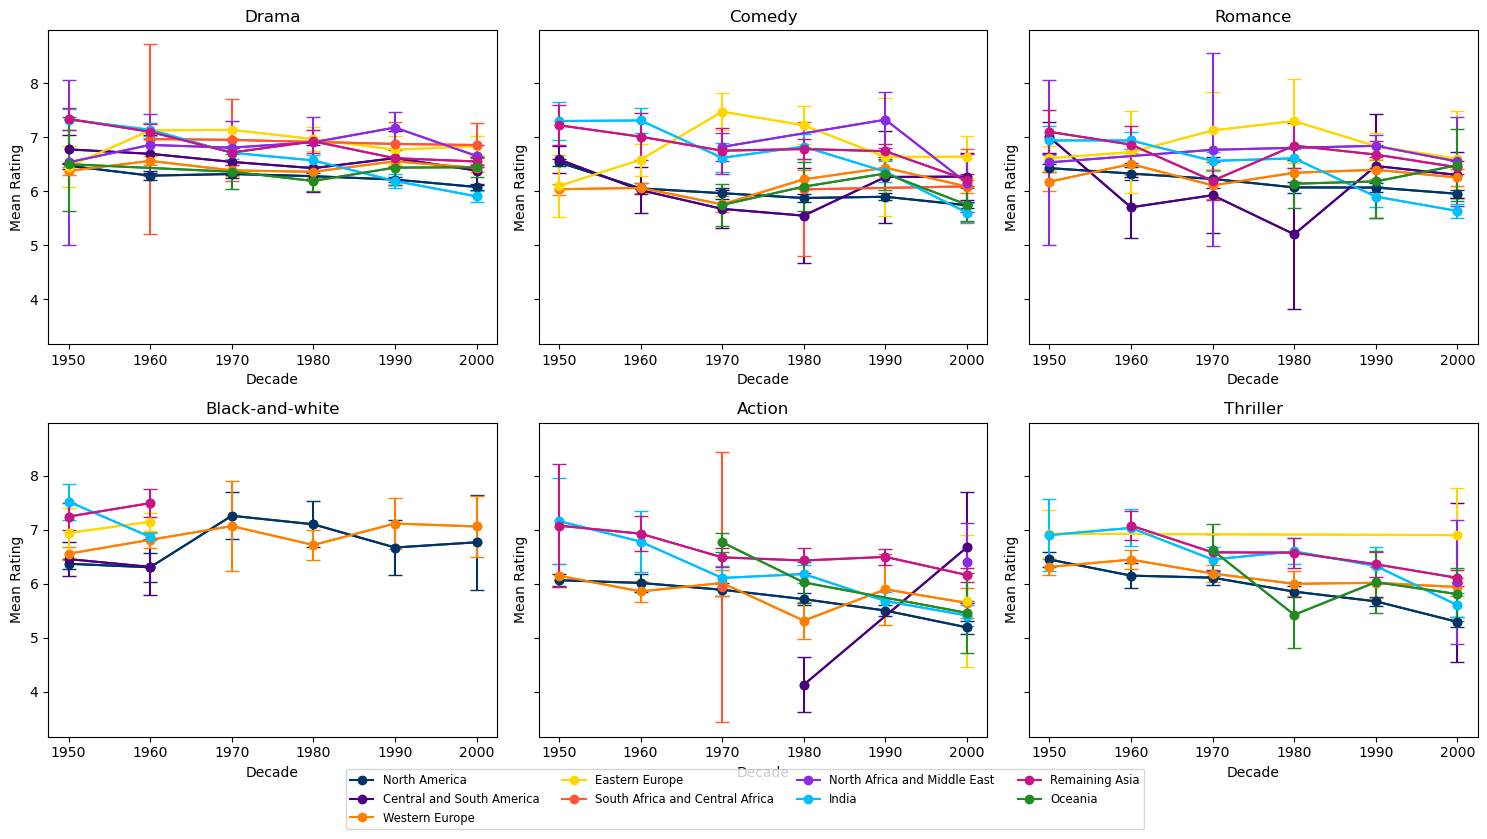

In [63]:
# plotting the results
ratings_visualizations.plot_genre_region_mean_ratings(mean_ratings, 
    confidence_intervals,
    list(regions.keys()),
    decades,
    regions_colors
)

Let's replicate the above over the top 20 genres.

In [64]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# The movies must be 'binned' into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [65]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_20_genres,               
    list(regions.keys()),                         
    decades               
)

In [66]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_region_decade_statistics(
    df_movies_ratings_region_decadefilled, 
    top_20_genres,                             
    list(regions.keys()),                           
    decades                              
)

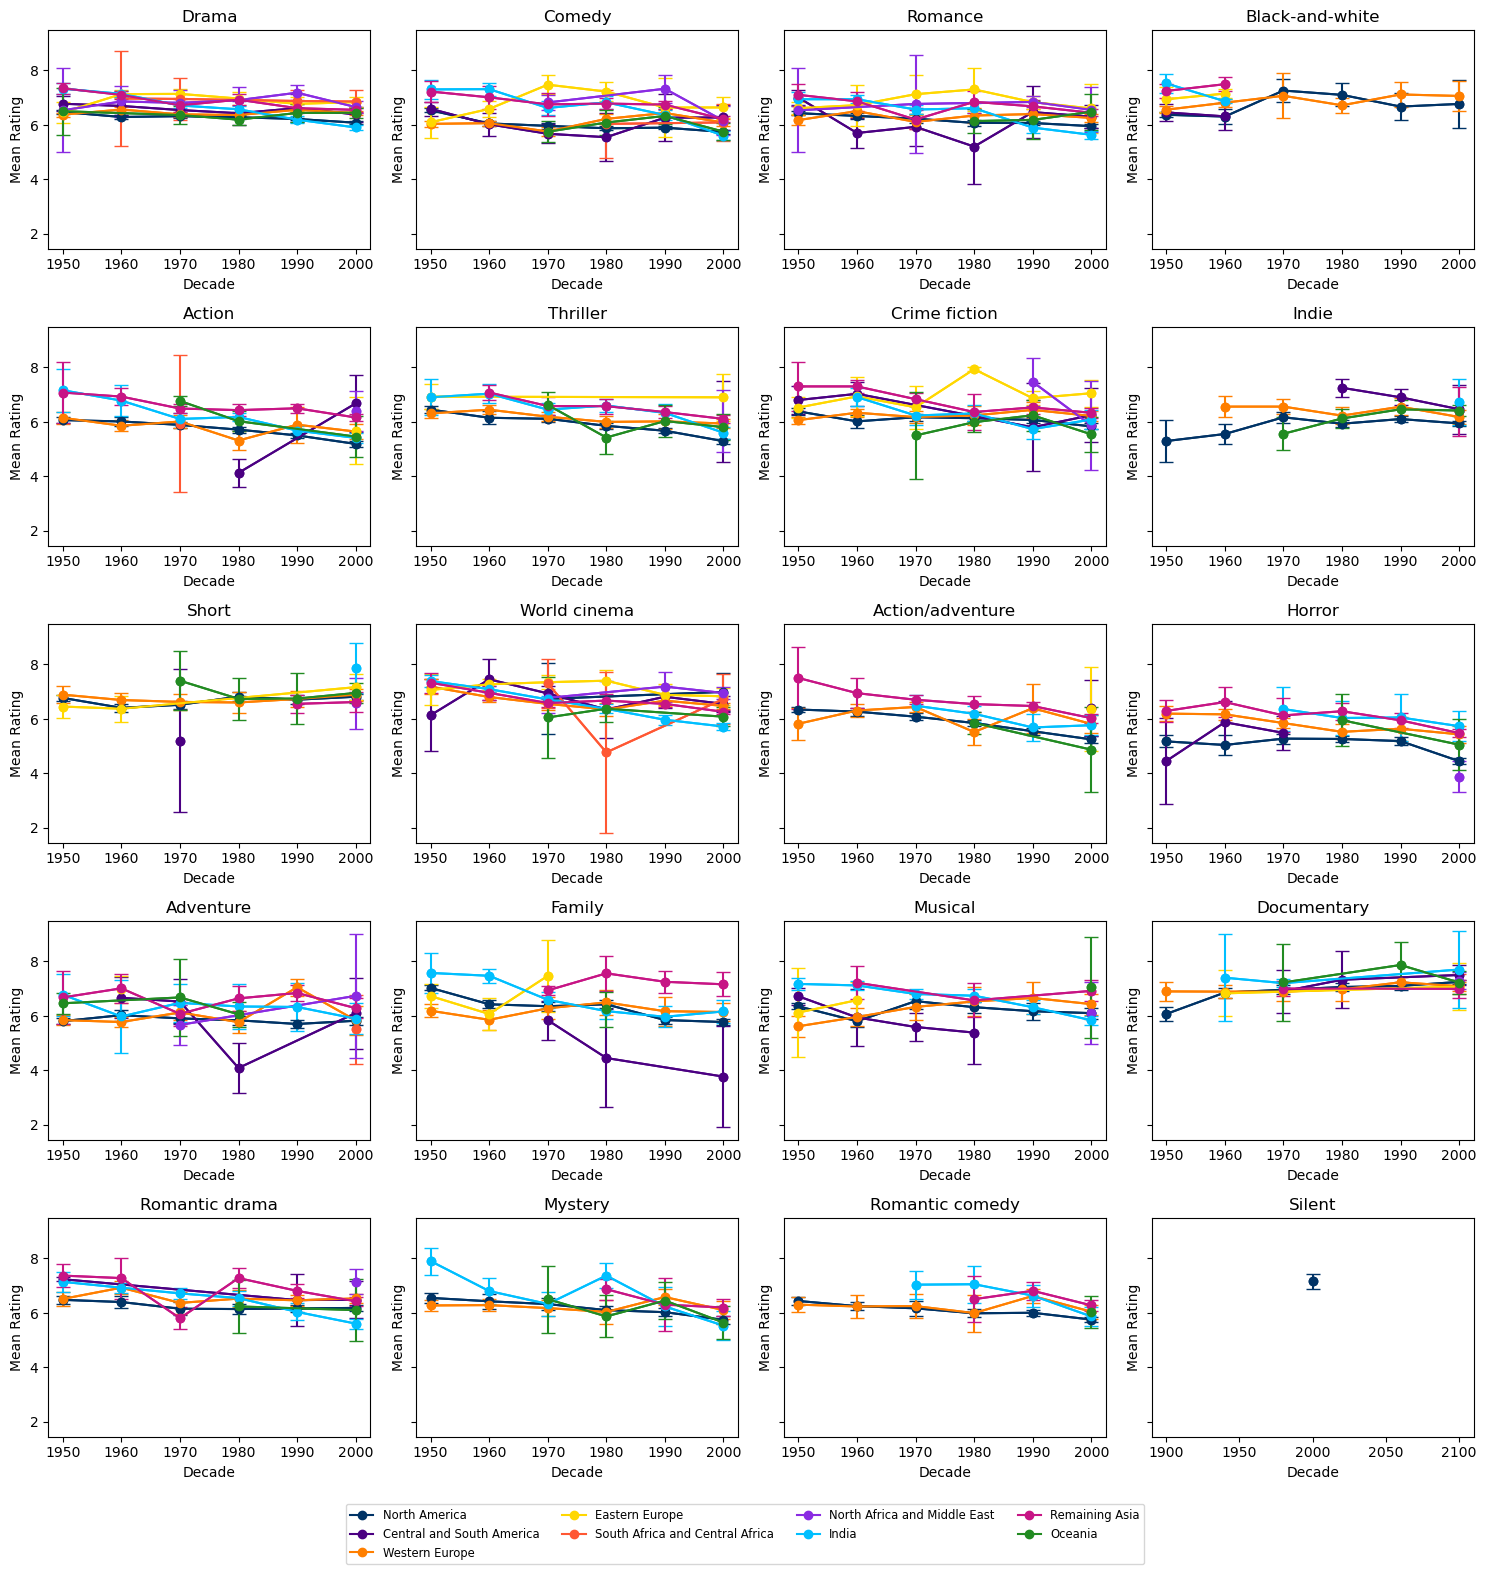

In [67]:
# plotting the results
ratings_visualizations.plot_genre_region_mean_ratings(mean_ratings, 
    confidence_intervals,
    list(regions.keys()),
    decades,
    regions_colors,
    (5, 4)
)

## 5.2 - Introduction Statistics

In [516]:
# wanting to analyze the significance of difference between ratings per region; there is complete independency of a given genre's ratings per region
# as no movies were exploded for country hence no movies can be counted in more than one region and the ratings are assumed to be normally distributed,
# hence ANOVA is performed to determine if within a given genre their ratings by region are statistically significantly different

# H_o = the null hypothesis: There is no significant difference among a given genre's rating means across movie regions
# H_a = the alternative hypothesis: There is a significant difference among a given genre's rating means across movie regions

p_values = {}
# Loop through each genre
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]

    C_SA_genre_ratings = genre_df[genre_df["region"] == "Central and South America"]
    C_SA_genre_ratings_list = C_SA_genre_ratings["averageRating"].to_list()

    EU_genre_ratings = genre_df[genre_df["region"] == "Eastern Europe"]
    EU_genre_ratings_list = EU_genre_ratings["averageRating"].to_list()

    India_genre_ratings = genre_df[genre_df["region"] == "India"]
    India_genre_ratings_list = India_genre_ratings["averageRating"].to_list()

    NA_ME_genre_ratings = genre_df[genre_df["region"] == "North Africa and Middle East"]
    NA_ME_genre_ratings_list = NA_ME_genre_ratings["averageRating"].to_list()

    NA_genre_ratings = genre_df[genre_df["region"] == "North America"]
    NA_genre_ratings_list = NA_genre_ratings["averageRating"].to_list()

    Oceania_genre_ratings = genre_df[genre_df["region"] == "Oceania"]
    Oceania_genre_ratings_list = Oceania_genre_ratings["averageRating"].to_list()

    RA_genre_ratings = genre_df[genre_df["region"] == "Remaining Asia"]
    RA_genre_ratings_list = RA_genre_ratings["averageRating"].to_list()

    SA_CA_genre_ratings = genre_df[genre_df["region"] == "South Africa and Central Africa"]
    SA_CA_genre_ratings_list = SA_CA_genre_ratings["averageRating"].to_list()

    WE_genre_ratings = genre_df[genre_df["region"] == "Western Europe"]
    WE_genre_ratings_list = WE_genre_ratings["averageRating"].to_list()

    # Checking if all regions in a given genre have ratings that aren't the filler 0 values
    if all(len(ratings) > 0 and all(rating != 0.0 for rating in ratings) for ratings in [
        C_SA_genre_ratings_list, EU_genre_ratings_list, India_genre_ratings_list,
        NA_ME_genre_ratings_list, NA_genre_ratings_list, Oceania_genre_ratings_list,
        RA_genre_ratings_list, SA_CA_genre_ratings_list, WE_genre_ratings_list]):
        
        # Performing ANOVA
        result = f_oneway(
            C_SA_genre_ratings_list, EU_genre_ratings_list, India_genre_ratings_list,
            NA_ME_genre_ratings_list, NA_genre_ratings_list, Oceania_genre_ratings_list,
            RA_genre_ratings_list, SA_CA_genre_ratings_list, WE_genre_ratings_list)
        
        p_values.update({str(genre): result[1]})

    else:
        # If any region lacks data, store None or a placeholder
        p_values.update({str(genre): None})
    
p_values

{'Drama': 4.617875036697544e-76,
 'Comedy': 6.422004075583201e-20,
 'Romance': 1.7009135085609594e-15,
 'Black-and-white': None,
 'Action': 7.561306631524561e-20,
 'Thriller': 4.993613222040955e-22,
 'Crime fiction': 1.0474470592318481e-08,
 'Indie': None,
 'Short': 0.012476459070900585,
 'World cinema': 1.255100807577101e-28,
 'Action/adventure': 4.786750036475877e-13,
 'Horror': 3.6947176687403628e-37,
 'Adventure': 4.4467261557217706e-06,
 'Family': 1.4399029453870017e-13,
 'Musical': None,
 'Documentary': 0.45306890527584676,
 'Romantic drama': 2.9798438198160703e-13,
 'Mystery': 0.004860230598355087,
 'Romantic comedy': 0.11932125034174818,
 'Silent': None}

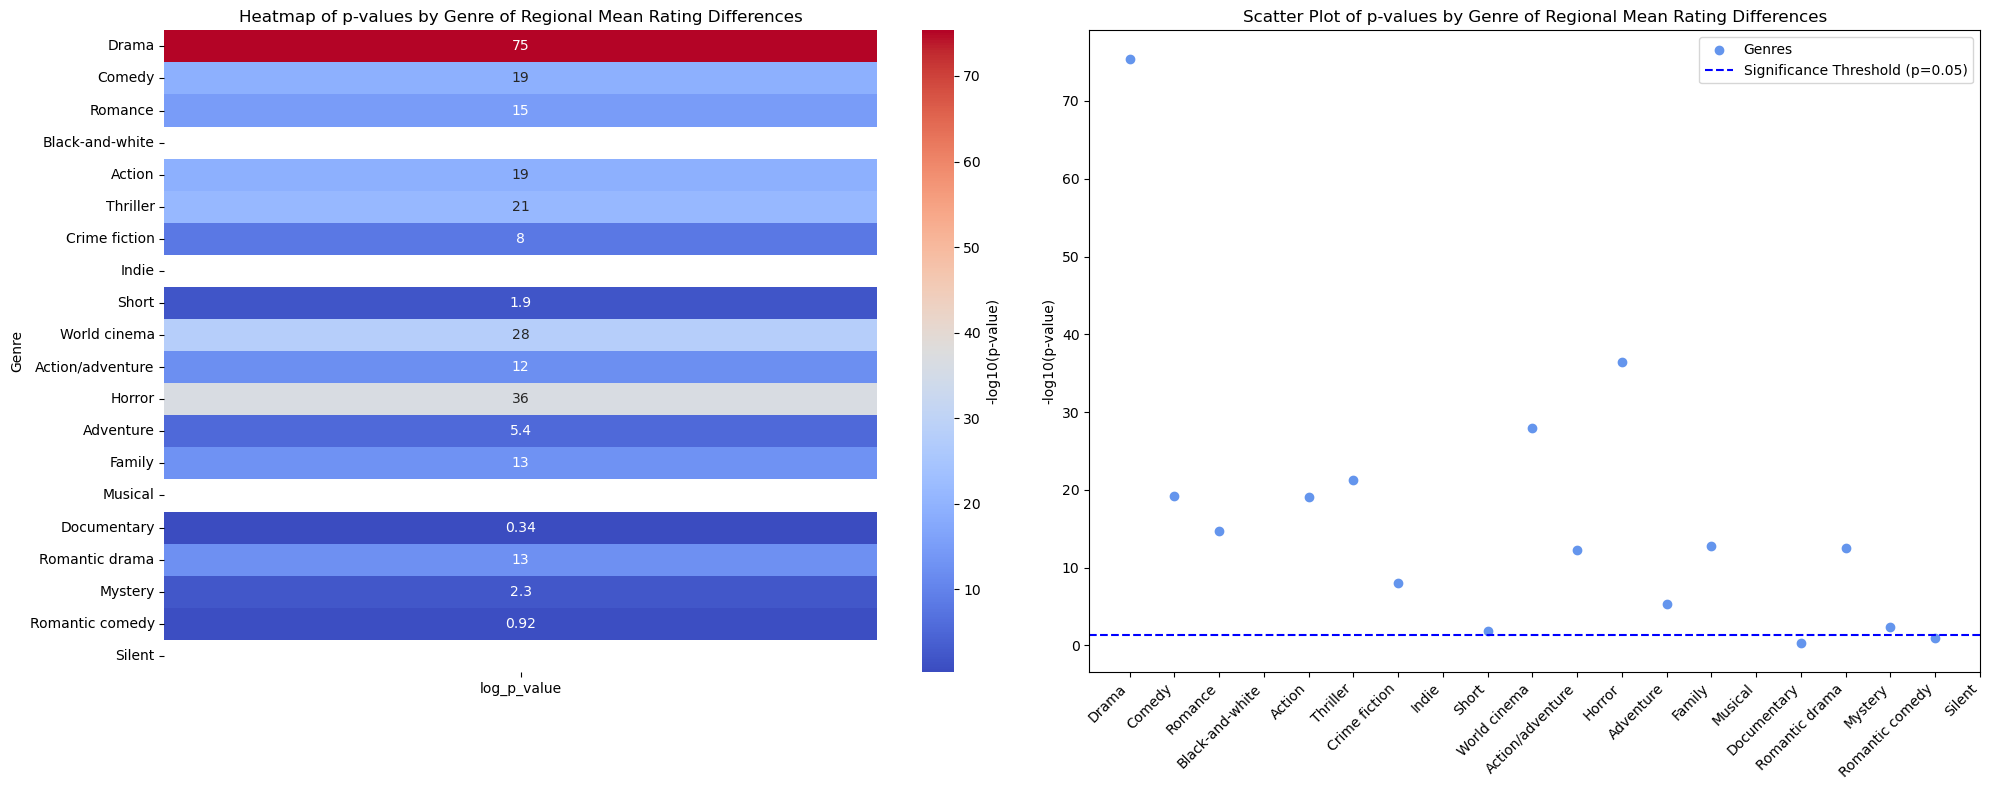

In [517]:
# To help plot (in various ways) the ANOVA p-value per genre, the above test results are converted to a DataFrame
df_genre_region_p_value = pd.DataFrame(list(p_values.items()), columns=['Genre', 'p-value'])

# Converting p-values to a heatmap-friendly range (log scale for better visualization)
df_genre_region_p_value['log_p_value'] = -df_genre_region_p_value['p-value'].apply(lambda x: np.log10(x) if x > 0 else None)

# A heat map is first prepared to observe which genres have significant in mean ratings across regions
heatmap_data = df_genre_region_p_value.set_index('Genre')[['log_p_value']]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create heatmap
# Plot heatmap
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': '-log10(p-value)'}, ax=axes[0])
axes[0].set_title('Heatmap of p-values by Genre of Regional Mean Rating Differences')

# Scatter plot
top_20_genres_list = df_genre_region_p_value['Genre'].tolist()
axes[1].scatter(top_20_genres_list, df_genre_region_p_value['log_p_value'], color='cornflowerblue', label='Genres')
axes[1].axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='Significance Threshold (p=0.05)')
axes[1].set_xticks(range(len(top_20_genres_list)))
axes[1].set_xticklabels(top_20_genres_list, rotation=45, ha='right')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_title('Scatter Plot of p-values by Genre of Regional Mean Rating Differences')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Most movies genres reject that there is no statistically significant difference in their ratings across regions and therefore we consider regional differences to have an impact on the mean ratings per genre. Documentaries and romantic comedies are the sole movies that fail to conclude a statistically significant difference in their mean ratings seperated by movie country.

Now we aim to understand if there is significance in the mean ratings across genres for a given movie region. For this, new hypothesis tests are prepared:

H_o = the null hypothesis: There is no significant difference among a given region's mean ratings across genres
H_a = the alternative hypothesis: There is a significant difference among a given region's mean ratings across genres

As there are some movies that appear in more than one genre, then we have to consider that we are in a situation where our samples are not entirely independent, which is a requirement for using one-way ANOVA testing, and hence the sample ratings may not fit a normal distribution. As a result, a Kruskal-Wallis Test is used per regional groupign of movies. A linear-mixed model would also be applicable for such an analysis, however, this test requires a linear relationship between the ratings and genre hot-encoded features, which we cannot prove. The Kruskal-Wallis Test is therefore called on each regional grouping.

In [518]:
# Looping through each region
for region in model_groupings:
    print(f"Results for region: {region}")
    
    # Dividing the data for the region
    df_region = df_movies_tmdb_ratings[df_movies_tmdb_ratings['region'] == region]
    
    # Collecting ratings for each genre
    genre_groups = []

    # Grouping the regional movies by genres
    for genre, group in df_region.groupby('genres'):
        # Extracting the ratings column for the current genre and append it as an array to the list of genre ratings
        ratings = group['averageRating'].values
        genre_groups.append(ratings)    

    # Performing the Kruskal-Wallis test across the genres by unpacking each list of ratings per genre
    if len(genre_groups) > 1:
        stat, p_value = kruskal(*genre_groups)
        print(f"Kruskal-Wallis Statistic: {stat:.4f}, p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"There null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in {region}.")
        else:
            print(f"The null hypothesis is failed to be rejected and a statistically significant difference in ratings across genres cannot be claimed for movies in {region}.")
    
    # Formatting in a clear way
    print("\n" + "-"*50 + "\n")


Results for region: Central and South America
Kruskal-Wallis Statistic: 91.6479, p-value: 0.0000
There null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in Central and South America.

--------------------------------------------------

Results for region: Eastern Europe
Kruskal-Wallis Statistic: 24.0638, p-value: 0.1937
The null hypothesis is failed to be rejected and a statistically significant difference in ratings across genres cannot be claimed for movies in Eastern Europe.

--------------------------------------------------

Results for region: India
Kruskal-Wallis Statistic: 181.1178, p-value: 0.0000
There null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in India.

--------------------------------------------------

Results for region: North Africa and Middle East
Kruskal-Wallis Statistic: 45.5213, p-value: 0.0002
There null hypothes